In [96]:
"""
Jupyter-notebook for integrating Open and Globular cluster data, want an outputted 
csv file with the following columns (maybe more):

Name, mass (Msun), dist(kpc), Z, age (Myr), Rhm (pc), velocity dispersion, 
cluster RA, cluster Dec, OpSim RA, OpSim Dec, OpSim ID, OC/GC Flag, Sigma source (calc, hmf, pisk, drawn)


"""

'\nJupyter-notebook for integrating Open and Globular cluster data, want an outputted \ncsv file with the following columns (maybe more):\n\nName, mass (Msun), dist(kpc), Z, age (Myr), Rhm (pc), velocity dispersion, \ncluster RA, cluster Dec, OpSim RA, OpSim Dec, OpSim ID, OC/GC Flag, Sigma source (calc, hmf, pisk, drawn)\n\n\n'

In [97]:
# importing needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord, Angle

In [98]:
# Reading in full cluster files
names_gc = ['Index','ID_x', 'Name', 'RA', 'DEC', 'L','B','R_Sun','R_gc','X','Y', 'Z', 'key_0','[Fe/H]_x', 'wt', 'E(B-V)_x',\
 'V_HB','(m-M)V_x', 'V_t', 'M_V,t', 'U-B', 'B-V', 'V-R', 'V-I', 'spt', 'ellip', 'ID_y', 'v_r', '+/-', 'v_LSR' ,'sig_v' ,'+/-.1', 'c', 'r_c', 'r_h', 'mu_V',\
  'rho_', 'lg(tc)', 'lg(th)', 'Mcl[Msun]', 'rh[pc]', '[Fe/H]_y', 'age[Gyr]', '(m-M)V_y', 'E(B-V)_y', 'log10(rho[Msun]/pc^3)',\
 'rc', 'sigma0[km/s]', 'esigma0[km/s]', 'fb', 'efb', '[M/H]', 'Rgc[kpc]','Rsun[kpc]']

names_oc = [ 'name', 'RA', 'DEC', 'l', 'b', 'Dist', 'Mod', 'EB-V', 'Age', 'ST', 'Z', 'Diam',\
            'Fe/H', 'MRV', "pm RA" ,"pm Dec", 'w flag','logM[Msun]', 'rtP[pc]', 'log(t[yr])K', 'rcK[pc]',\
            'rtK[pc]', 'Rhm[pc]', '[Fe/H]K]', 'distanceK[pc]', 'p flag','deltaV', 'sigdV', '[FeH]', 'sigFeH', 't', 'sigt' ,'logt',\
            'Rgc', 'z', 'Diam[pc]', 'd[pc]', 's flag']
# print(len(names_oc))
GC_readin = pd.read_csv('/Users/andrewbowen/ceb_project/data/GC_data/gc_data.txt', \
                  sep = ' ',header = 0, names = names_gc)
OC_readin = pd.read_csv('/Users/andrewbowen/ceb_project/data/OC_data/oc_data.txt', \
                  sep = ' ', header = 0, names = names_oc)

In [99]:
# Dropping unnecessary GC labels (photometry stuff, etc)
GCs = GC_readin.drop(labels = ['Index','Name', 'L', 'B', 'R_gc', 'X','Y', 'Z','key_0', 'wt', 'E(B-V)_x',\
                   'V_HB','(m-M)V_x', 'V_t', 'M_V,t', 'U-B', 'B-V', \
                   'V-R', 'V-I', 'spt', 'ellip', 'ID_y', 'v_r',\
               '+/-', 'v_LSR', 'sig_v','+/-.1', 'c', 'r_h','mu_V', 'rho_',\
       'lg(tc)', 'lg(th)', '[Fe/H]_y','(m-M)V_y', 'E(B-V)_y', 'log10(rho[Msun]/pc^3)',\
               'rc','esigma0[km/s]', 'fb', 'efb', '[M/H]','Rgc[kpc]', 'Rsun[kpc]'], axis = 1)


In [100]:
# GC age conversion from Gyr to Myr for ~consistency~
GCs['age[Gyr]'] = GCs['age[Gyr]'] * (10**3)

In [101]:
GCs.columns

Index(['ID_x', 'RA', 'DEC', 'R_Sun', '[Fe/H]_x', 'r_c', 'Mcl[Msun]', 'rh[pc]',
       'age[Gyr]', 'sigma0[km/s]'],
      dtype='object')

In [102]:
# Renaming Globular Cluster Column labels
GCs.columns = ['Name', 'RA', 'Dec', 'dist[kpc]', 'Z',\
                     'r_c', 'mass[Msun]', 'rh[pc]', 'Age',\
                      'sigma[km/s]']



In [103]:
# Trying to convert GC core radius to parsecs (from arcmin), maybe with astropy
gc_rc = GCs['r_c'].values * u.arcmin#setting up astropy units instance
gc_rc = gc_rc.to(u.radian)

# Converting distances from kpc to pc (for now)
gc_dist = GCs['dist[kpc]'].values * u.kpc
gc_dist = gc_dist.to(u.parsec)

# Plugging in values into ang diam*distance formula
gc_Rcore = np.tan(gc_rc) * gc_dist#linear size from core-radius param (small-angle approx)

# Re-setting GCs core radius column to parsecs
GCs['r_c'] = gc_Rcore


In [104]:
# Renaming and dropping columns from OC datafram
OCs = OC_readin.drop(labels = ['Z','l', 'b', 'Mod', 'EB-V', 'ST', 'MRV', 'pm RA', \
                         'pm Dec','rtP[pc]', 'rcK[pc]', 'rtK[pc]','deltaV',\
                        'sigdV','sigFeH','sigt', 'Rgc'], axis = 1)

In [105]:
# Combining OC flags that tell us which data source they came from
OCs['ps flag'] = OCs['p flag'].combine_first(OCs['s flag'])#combining piksunov and solaris flags first
OCs['Source Flag'] = OCs['w flag'].combine_first(OCs['ps flag'])
OCs = OCs.drop(labels = ['w flag', 'p flag', 's flag', 'ps flag'], axis = 1)


In [106]:
# OC age conversions (W & S)
OCs['t'] = OCs['t'] * (10**3)#converting Solaris age from Gyr to Myr
OCs['Age'] = OCs['Age'] * (10**3)#Converting Webda ages from Gyr to Myr

In [107]:
# Combining the webda and solaris distances and putting them in a kpc series attached to OCs
webda_dist = OCs['Dist']#webda distance
sol_dist = OCs['d[pc]']#Solaris distance, may need to check Piskunov paper for any distances
pisk_dist = OCs['distanceK[pc]']

# Combining Piskunov and solaris distances (Piskunov first)
PS_dist = pisk_dist.combine_first(sol_dist)

# Combining WEBDA distance with the other 2 distances (WEBDA first)
oc_all_dist = webda_dist.combine_first(PS_dist)

# Converting all distances from pc to kpc
oc_dist_pc = oc_all_dist.values * u.parsec
oc_dist_kpc = oc_dist_pc.to(u.kpc)
OCs['dist[kpc]'] = oc_dist_kpc


In [108]:
# Combining the oc log age column as well - From Piskunov
oc_logage = 10 ** OCs['log(t[yr])K'].values#converting from log-years to years (exponentiation)
oc_logage = oc_logage * u.yr
oc_age_pisk = oc_logage.to(u.Myr)#converting piskunov age to Myr, which we want for our EBLSST code
OCs['Pisk Age'] = oc_age_pisk

# Dropping old separate distance columns from webda and solaris from dataframe, also old Piskunov log-age column
OCs = OCs.drop(labels = ['Dist','log(t[yr])K', 'distanceK[pc]','d[pc]'], axis = 1)

In [109]:
# Merging OC metallicities - need to figure out how we deal with bad values
oc_Z_pisk = OCs['[Fe/H]K]']#Piskunov metallicity, some nans
oc_Z_webda = OCs['Fe/H']#webda metallicity
oc_Z_sol = OCs['[FeH]']#Solaris metallicity

# Combining different metallicity columns into one column with all OC metallicity values
Zoc_pw = oc_Z_webda.combine_first(oc_Z_pisk)#merging pisk and webda metallicities
oc_Z = Zoc_pw.combine_first(oc_Z_sol)#merging other two with solaris metallicities - now we have all 3

In [110]:
# Setting up new metallicity column for OC dataframe, contains all 3 metallicities
OCs['Z'] = oc_Z

#Dropping unnecessary metallicity columns (from all 3 separate OC databases)
OCs = OCs.drop(labels = ['Fe/H', '[Fe/H]K]', '[FeH]'], axis = 1)

In [111]:
# Merging Piskunov age and webda age (and solaris)
oc_age_sol = OCs['t']#Solaris age (already converted to Myr from Gyr in file)
oc_agePS = OCs['Pisk Age'].combine_first(oc_age_sol)#Solaris and Piskunov ages merged

oc_age_all = OCs['Age'].combine_first(oc_agePS)#combinging Pisk, Solaris ages with webda age
OCs['Age[Myr]'] = oc_age_all

# dropping old separated ages and z column (height to galactic plane from Solaris 2004)
OCs = OCs.drop(labels = ['Age', 't', 'logt', 'z','Pisk Age'], axis =1)

In [112]:
# Converting OC masses from log mass (Piskunov values)
oc_log_mass = OCs['logM[Msun]']
oc_mass = 10 ** oc_log_mass#converting from log mass to solar mass

In [113]:
# Converting log mass to solar masses
OCs['mass[Msun]'] = oc_mass
OCs = OCs.drop(labels = ['logM[Msun]'], axis = 1)#dropping old log mass column

In [114]:
# Dropping arcmin diameter (WBEDA) from dataframe
# OCs = OCs.drop(labels = ['Diam'], axis =1)


In [115]:
# renaming the oc half-mass radius column to match up with the GC columns
OCs.columns = ['Name','RA', 'Dec', 'Diam', 'rh[pc]', 'Diam[pc]', 'Source Flag','dist[kpc]', 'Z',
       'Age', 'mass[Msun]']

In [116]:
# Merging Diam/rh columns for OCs

# Diams/rhms from each OC source
webda_diam = OCs['Diam']
pisk_rhm = OCs['rh[pc]']
sol_diam = OCs['Diam[pc]']

WS_diam = webda_diam.combine_first(sol_diam)

# Combining all into one series
OC_all_diam = pisk_rhm.combine_first(WS_diam)

In [117]:
# Dropping old Rhm/Diam values from OC dataframe and adding new combined series of all 3
OCs = OCs.drop(labels = ['Diam', 'rh[pc]', 'Diam[pc]'], axis =1)

# Setting new column value to combined series
OCs['rh[pc]'] = OC_all_diam


In [118]:
# Getting OpSim ID, RA and Dec for both, borrowing heavily from out number_crunching script
dat_obs = pd.read_csv('/Users/andrewbowen/ceb_project/data/opsim_field_data.csv', \
		delim_whitespace = True, header = 0, names = ['ID', 'RA', 'Dec', 'Nobs'])

In [119]:
# Creating OpSim field coords
OpSimRA = dat_obs['RA']
OpSimDec = dat_obs['Dec']
OpSimID = dat_obs['ID']
lsst_Coords = SkyCoord(OpSimRA, OpSimDec, unit=(u.degree, u.degree), frame='icrs')

# Wrapping coords
lsst_RAWrap = lsst_Coords.ra.wrap_at(180.*u.degree).radian
lsst_DecWrap = lsst_Coords.dec.wrap_at(180.*u.degree).radian


In [120]:
# Setting up RA instances
GC_RA = Angle(GCs['RA'], unit = u.hour)
GC_RA = GC_RA.degree
# oc_ra = OCs['RA']
# OC_RA = oc_ra.dropna(how = 'any')
OC_RA = Angle(OCs['RA'], unit = u.hour)
OC_RA = OC_RA.degree
print(OC_RA)
# Setting up Declination instances
GC_Dec = GCs['Dec']
OC_Dec = OCs['Dec']
OC_Dec = Angle(OC_Dec, unit = u.degree)

[154.05416667 305.35        97.6125     ... 234.7725     286.314
 356.95      ]


In [121]:
# Setting up OC/GC coords for matching
OC_Coords = SkyCoord(OC_RA, OC_Dec, unit=(u.degree, u.degree), frame='icrs')
GC_Coords = SkyCoord(GC_RA, GC_Dec, unit=(u.degree, u.degree), frame='icrs')

In [122]:
# looping through both cluster sets and using match_()

# Globular Clusters first
GC_OpSimRA = []
GC_OpSimDec = []
GC_OpSimID = []

for index, row in GCs.iterrows():

    coords = SkyCoord(row['RA'], row['Dec'], unit = (u.degree, u.degree), frame = 'icrs')#lsst coords to be compared (all OpSim field coords)
    rad_deg = Angle(row['rh[pc]'], unit = u.arcmin)#cluster radius (half-mass in )
    
    imin, sep1, dist3d = coords.match_to_catalog_sky(lsst_Coords, nthneighbor = 1)

    GC_OpSimRA.append(lsst_Coords[imin].ra)
    GC_OpSimDec.append(lsst_Coords[imin].dec)
    GC_OpSimID.append(dat_obs['ID'].loc[imin.item()])


In [123]:
# Putting GC OpSim fields into dataframe

GCs['OpSim ID'] = GC_OpSimID
GCs['OpSim RA'] = GC_OpSimRA
GCs['OpSim Dec'] = GC_OpSimDec

In [124]:
# print(OCs['RA'].to_string())

In [125]:
# Open Clusters next
OC_OpSimRA = []
OC_OpSimDec = []
OC_OpSimID = []#list that contains OpSim IDs of matched OC/Lsst coords, one for each OC
# n = 0 
for index, row in OCs.iterrows():

#     print(row['RA'])
    coord = SkyCoord(row['RA'], row['Dec'], unit = (u.hour, u.degree), frame = 'icrs')#lsst coords to be compared (all OpSim field coords)

#     Matching OC coordinates with lsst coords using astropy
    imin, sep1, dist3d = coord.match_to_catalog_sky(lsst_Coords)

#   Matched RA/DEC - indexing into LSST coords
    OpSimMatchRA = lsst_Coords[imin].ra
    OpSimMatchDec = lsst_Coords[imin].dec

    OC_OpSimRA.append(OpSimMatchRA)
    OC_OpSimDec.append(OpSimMatchDec)
    OC_OpSimID.append(dat_obs['ID'].loc[imin.item()])#indexes into lsst_Coords, can us to get OpSim ID later



    
print(OC_OpSimRA)

[<Longitude 154.2084198 deg>, <Longitude 304.17459106 deg>, <Longitude 97.23486328 deg>, <Longitude 101.7225647 deg>, <Longitude 101.7225647 deg>, <Longitude 112.96591187 deg>, <Longitude 68.2908783 deg>, <Longitude 208.15686035 deg>, <Longitude 280.20980835 deg>, <Longitude 261.46429443 deg>, <Longitude 283.1885376 deg>, <Longitude 311.63500977 deg>, <Longitude 324.00003052 deg>, <Longitude 169.06591797 deg>, <Longitude 100.1078949 deg>, <Longitude 107.99998474 deg>, <Longitude 109.56011963 deg>, <Longitude 299.78277588 deg>, <Longitude 304.36444092 deg>, <Longitude 321.01608276 deg>, <Longitude 120.63777161 deg>, <Longitude 131.349823 deg>, <Longitude 132.91827393 deg>, <Longitude 138.50352478 deg>, <Longitude 139.27217102 deg>, <Longitude 141.45388794 deg>, <Longitude 144.00003052 deg>, <Longitude 144.00003052 deg>, <Longitude 144.00003052 deg>, <Longitude 146.54614258 deg>, <Longitude 152.91844177 deg>, <Longitude 150.61276245 deg>, <Longitude 149.49645996 deg>, <Longitude 153.4337

In [126]:
# Setting OC column values to our list OpSim field ra, dec and id above - filling in NaN values

OCs['OpSim ID'] = OC_OpSimID
OCs['OpSim RA'] = OC_OpSimRA
OCs['OpSim Dec'] = OC_OpSimDec


In [127]:
# Rearranging column labels from stack overflow: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
GCs['Cluster Type'] = np.array(['G'] * len(GCs))

In [128]:
GCcols = ['Name', 'RA', 'Dec', 'dist[kpc]', 'Z','rh[pc]','r_c','mass[Msun]',\
          'Age', 'sigma[km/s]','OpSim ID', 'OpSim RA', 'OpSim Dec', 'Cluster Type']


In [129]:
GCs = GCs[GCcols]
# GCs

In [130]:
# Adding Cluster Type flag to each OC/GC dataframe

# Adding cluster type flag to dataframe (Open or Globular)
OCs['Cluster Type'] = np.array(['O'] * len(OCs))

OCcols = ['Name','RA', 'Dec','dist[kpc]','rh[pc]',  'mass[Msun]','Age',\
         'Z', 'OpSim ID', 'OpSim RA', 'OpSim Dec','Source Flag','Cluster Type']

# Resetting column labels for Open Clusters (order matches GCs now, easier to concet later)
OCs = OCs[OCcols]

In [131]:
# Sending these cleaned OC/GC dataframes to separate csv files
OCs.to_csv('~/ceb_project/data/oc-data-cleaned.csv', sep = ' ')
GCs.to_csv('~/ceb_project/data/gc-data-cleaned.csv', sep = ' ')

In [132]:
# Function from aaron to make a cumulative distribution we can later draw sigma values from (if they are nans)
def makeCum(x):#x should be an array-like input (in this case )
    if (len(x) > 1):
        n = np.arange(1,len(x)+1) / np.float(len(x))
        xs = np.sort(x)
        return np.insert(xs, 0, min(xs)), np.insert(n, 0, 0.)
    else:
        return [0],[0]
    

In [133]:
# New
def get_sigma(Rh, Rc, M, ClusterDF):
    '''
    new function to improve on our get_sigma from above
    '''
    
    G = 1.334 * (10 ** 11)#Gravitational constant in km^3 M_sun ^ -1 s ^ -2 (consistent with cosmic output units)
    const = (3 * np.pi * G) /64
    
    
#     Checking for mass value existence first
    if M > 0 and not np.isnan(M):
#         Checking for half-mass radius first
        if np.isfinite(Rh) and Rh > 0:#best case scenario
            Rh = Rh * (3.086 * (10**13)) #converting to pc from km
            a = Rh / 1.305 
            sigma_rh = np.sqrt(const * M/a)    
            flag = 'rh'

            return sigma_rh, flag
        
#         If there is a mass but no Rhm listed, check for core radius
        elif np.isfinite(Rc)and Rc > 0:
            Rc = Rc * (3.086 * (10**13)) #converting to pc from km
            a = np.sqrt(2) * Rc
            sigma_rc = np.sqrt(const * M/a)
            flag = 'rc'

            return sigma_rc, flag
            
#         If there is a mass but no Rc or Rh, draw an Rh randomly
        else:#picking out good rhm values to draw from

#             Making a cumulative distribution of all good able half-mass radii
            CumRhDist = makeCum(ClusterDF['rh[pc]'].loc[(np.isfinite(ClusterDF['rh[pc]'])) & \
                            (ClusterDF['rh[pc]'] >0)])
#           Drawing from the distribution created above, and converting to km from pc
            y = np.random.random()#random y value to use as interpolation pt
            DrawnRh = np.interp(y, CumRhDist[1], CumRhDist[0])  * (3.086 * (10**13))

            a = DrawnRh / 1.305
            sigma_rhD = np.sqrt(const * M/a)#rhD for half-mass radius 'Drawn'
            flag = 'rh*'#star indicates that value is drawn from dist
            return sigma_rhD, flag
        
#     if there is not a mass given
    elif np.isnan(M) or M < 0:
        
#         Drawing a random mass, can change distribution later
        CumMassDist = makeCum(ClusterDF['mass[Msun]'].loc[(np.isfinite(ClusterDF['rh[pc]'])) &\
                                (ClusterDF['mass[Msun]'] >0)])#Drawing a random mass from a cumulative distribution of cluster masses
    
#       Choosing randomly from our cumulative distribution of cluster masses
        y = np.random.random()#Random value from 0 to 1 as interpolation pt
#         drawnMass = np.random.choice(CumMassDist)
        drawnMass = np.interp(y, CumMassDist[1], CumMassDist[0])
        
        
#         if there is a half-mass radius listed but no mass 
        if np.isfinite(Rh) and Rh > 0:
            Rh = Rh * (3.086 * (10**13)) #converting given half-mas radius to pc from km
            a = Rh / 1.305
            sigma_rh_MD = np.sqrt(const * drawnMass/a)    
            flag = 'm*rh'
            return sigma_rh_MD, flag
        
#         if there is a core-radius value listed (but no mass)
        elif np.isfinite(Rc) and Rc > 0:
            Rc = Rc * (3.086 * (10**13)) #converting given core radius to pc from km
            a = np.sqrt(2) * Rc
            sigma_rc_MD = np.sqrt(const * drawnMass/a)
            flag = 'm*rc'
            return sigma_rc_MD, flag
            
#         If there is a mass but no Rc or Rh, draw a Rh randomly - can change dist shape later (want cumulative of present good rhms)

        else:#This is the worst of all timelines

#             Making a cumulative distribution of all good able half-mass radii
            CumRhDist = makeCum(ClusterDF['rh[pc]'].loc[(np.isfinite(ClusterDF['rh[pc]'])) & \
                            (ClusterDF['rh[pc]'] > 0)])
            y_new = np.random.random()
#             drawing random half-mass radius from dristribution above and feeding to Plummer model
            DrawnRh = np.interp(y_new, CumRhDist[1], CumRhDist[0])  * (3.086 * (10**13))
    
            a = (DrawnRh / 1.305)
            sigma_crh_MD = np.sqrt(const * drawnMass/a)
            flag = 'm*rh*'

            return sigma_crh_MD, flag
        
        

In [134]:
# looping through OCs and applying our get_sigma function to every cluster, hope there's enough data

# Lists to append stuff to later
OCSigma = []
OCSigmaSource = []
n = 0

# Looping through every cluster (OC & GC) in our Clusters DF
for index, cluster in OCs.iterrows():
    
#     Setting up function inputs (half-mass radius, core radius, cluster mass)
    R_HalfMass = cluster['rh[pc]']
    R_Core = np.nan#no core radii given in OC dataframe, skipping over this
    Mcl = cluster['mass[Msun]']
    
#     Running get_sigma function on clusters
    sigma, flag = get_sigma(R_HalfMass, R_Core, Mcl, OCs)
    
#     Appending values and flags to lists
    OCSigma.append(sigma)
    OCSigmaSource.append(flag)
#     n += 1
    

# print(OCSigma)

In [135]:
# looping through GCs and applying our get_sigma function to every cluster, hope there's enough data

# Lists to append stuff to later
GCSigma = []
GCSigmaSource = []
n = 0

# Looping through every cluster (OC & GC) in our Clusters DF
for index, cluster in GCs.iterrows():
    
#     Setting up function inputs (half-mass radius, )
    R_HalfMass = cluster['rh[pc]']
    R_Core = cluster['r_c']
    Mcl = cluster['mass[Msun]']
    
#     Running get_sigma function on clusters
    sigma, flag = get_sigma(R_HalfMass, R_Core, Mcl, GCs)
    
#     Appending values and flags to lists
    GCSigma.append(sigma)
    GCSigmaSource.append(flag)
    n += 1

    
# print(GCSigma)

In [136]:
# Putting these new lists into our OC/GC dataframe

OCs['sigma_v[km/s]'] = pd.Series(OCSigma)
OCs['sigma_source'] = pd.Series(OCSigmaSource)

GCs['sigma_v[km/s]'] = pd.Series(GCSigma)
GCs['sigma_source'] = pd.Series(GCSigmaSource)



In [137]:
# Setting up dists for OCs and GCs
sigma_flags = ['rh', 'rc', 'rh*','m*rh', 'm*rc', 'm*rh*']

# Open Clusters

# Mass distributions first - grouping open cluster masses by which flag we used to get sigma
OCm_RH = OCs['mass[Msun]'].loc[OCs['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
OCm_RC = OCs['mass[Msun]'].loc[OCs['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
OCm_RHstar = OCs['mass[Msun]'].loc[OCs['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
OCm_Mstar_RH = OCs['mass[Msun]'].loc[OCs['sigma_source'] == 'm*rh']#No mass but an rhm
OCm_Mstar_RC = OCs['mass[Msun]'].loc[OCs['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
OCm_Mstar_RHstar = OCs['mass[Msun]'].loc[OCs['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

# All masses 
OCs_Mass = OCs['mass[Msun]']

# Now radii distributions - - grouping open cluster radii by which flag we used to get sigma
OCr_RH = OCs['rh[pc]'].loc[OCs['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
OCr_RC = OCs['rh[pc]'].loc[OCs['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
OCr_RHstar = OCs['rh[pc]'].loc[OCs['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
OCr_Mstar_RH = OCs['rh[pc]'].loc[OCs['sigma_source'] == 'm*rh']#No mass but an rhm
OCr_Mstar_RC = OCs['rh[pc]'].loc[OCs['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
OCr_Mstar_RHstar = OCs['rh[pc]'].loc[OCs['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

# OC Sigma values
OCsig_RH = OCs['sigma_v[km/s]'].loc[OCs['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
OCsig_RC = OCs['sigma_v[km/s]'].loc[OCs['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
OCsig_RHstar = OCs['sigma_v[km/s]'].loc[OCs['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
OCsig_Mstar_RH = OCs['sigma_v[km/s]'].loc[OCs['sigma_source'] == 'm*rh']#No mass but an rhm
OCsig_Mstar_RC = OCs['sigma_v[km/s]'].loc[OCs['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
OCsig_Mstar_RHstar = OCs['sigma_v[km/s]'].loc[OCs['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)


In [138]:
# Globular Clusters dists

sigma_flags = ['rh', 'rc', 'rh*','m*rh', 'm*rc', 'm*rh*']

# Mass distributions first - grouping globular cluster masses by which flag we used to get sigma
GCm_RH = GCs['mass[Msun]'].loc[GCs['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
GCm_RC = GCs['mass[Msun]'].loc[GCs['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
GCm_RHstar = GCs['mass[Msun]'].loc[GCs['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
GCm_Mstar_RH = GCs['mass[Msun]'].loc[GCs['sigma_source'] == 'm*rh']#No mass but an rhm
GCm_Mstar_RC = GCs['mass[Msun]'].loc[GCs['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
GCm_Mstar_RHstar = GCs['mass[Msun]'].loc[GCs['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

# All masses 
GC_Mass = GCs['mass[Msun]']

# Now radii distributions - - grouping globular cluster radii by which flag we used to get sigma
GCr_RH = GCs['rh[pc]'].loc[GCs['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
GCr_RC = GCs['rh[pc]'].loc[GCs['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
GCr_RHstar = GCs['rh[pc]'].loc[GCs['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
GCr_Mstar_RH = GCs['rh[pc]'].loc[GCs['sigma_source'] == 'm*rh']#No mass but an rhm
GCr_Mstar_RC = GCs['rh[pc]'].loc[GCs['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
GCr_Mstar_RHstar = GCs['rh[pc]'].loc[GCs['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

GC_Radius = GCs['rh[pc]']

# GC Sigma values
GCsig_RH = GCs['sigma_v[km/s]'].loc[GCs['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
GCsig_RC = GCs['sigma_v[km/s]'].loc[GCs['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
GCsig_RHstar = GCs['sigma_v[km/s]'].loc[GCs['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
GCsig_Mstar_RH = GCs['sigma_v[km/s]'].loc[GCs['sigma_source'] == 'm*rh']#No mass but an rhm
GCsig_Mstar_RC = GCs['sigma_v[km/s]'].loc[GCs['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
GCsig_Mstar_RHstar = GCs['sigma_v[km/s]'].loc[GCs['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

GC_Sigma = GCs['sigma_v[km/s]']

/Users/andrewbowen/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


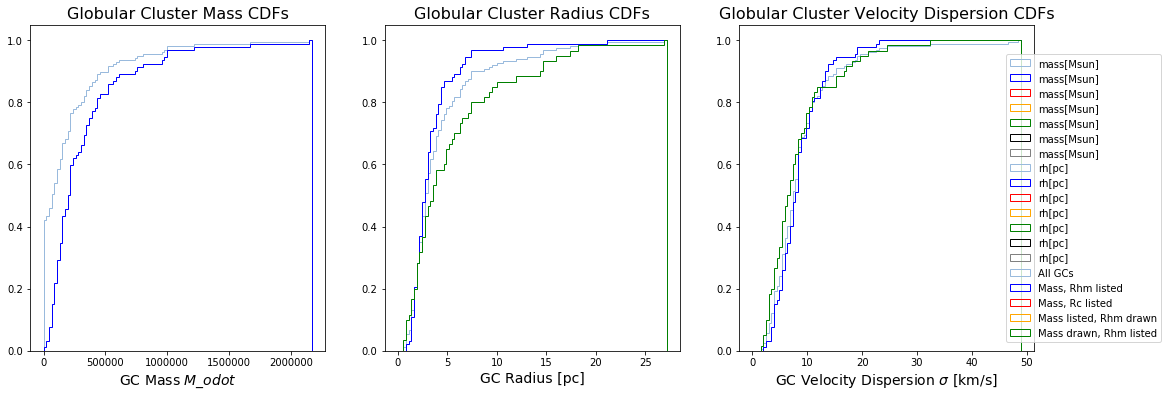

In [139]:
# ############################################ Globular Clusters ##################################

f,axarr = plt.subplots(1,3, figsize = (18,6))
f.subplots_adjust(wspace=0.2, hspace = 0.15)

# Mass First
axarr[0].hist(GC_Mass, bins = 100, color = '#99badd', histtype = 'step',\
        cumulative = True, fill = False, density = True)
axarr[0].hist(GCm_RH, bins = 100,  color = 'blue', range = (0, np.max(GC_Mass)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(GCm_RC, bins = 100,  color = 'red', range = (0, np.max(GC_Mass)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(GCm_RHstar, bins = 100,  color = 'orange',range = (0, np.max(GC_Mass)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(GCm_Mstar_RH, bins = 100,  color = 'green', range = (0, np.max(GC_Mass)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(GCm_Mstar_RC, bins = 100, color = 'black', range = (0, np.max(GC_Mass)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(GCm_Mstar_RHstar, bins = 100,  color = 'gray', range = (0, np.max(GC_Mass)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
        
axarr[0].set_title('Globular Cluster Mass CDFs', fontsize = 16)
axarr[0].set_xlabel('GC Mass $M\_odot$', fontsize = 14)

# GC Radius (middle panel)

axarr[1].hist(GC_Radius, bins = 100, color = '#99badd', range = (0, np.max(GC_Radius)),histtype = 'step',\
        cumulative = True, fill = False, density = True)
axarr[1].hist(GCr_RH, bins = 100,  color = 'blue', range = (0, np.max(GC_Radius)), \
         histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(GCr_RC, bins = 100,  color = 'red', range = (0, np.max(GC_Radius)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(GCr_RHstar, bins = 100,  color = 'orange',range = (0, np.max(GC_Radius)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(GCr_Mstar_RH, bins = 100,  color = 'green', range = (0, np.max(GC_Radius)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(GCr_Mstar_RC, bins = 100, color = 'black', range = (0, np.max(GC_Radius)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(GCr_Mstar_RHstar, bins = 100,  color = 'gray', range = (0, np.max(GC_Radius)),\
        histtype = 'step', fill = False , cumulative = True, density = True)

axarr[1].set_title('Globular Cluster Radius CDFs', fontsize = 16)
axarr[1].set_xlabel('GC Radius [pc]', fontsize = 14)

# GC Sigma

axarr[2].hist(GC_Sigma, bins = 100, color = '#99badd',  range = (0, np.max(GC_Sigma)),\
        label = 'All GCs', histtype = 'step', cumulative = True, fill = False, density = True)
axarr[2].hist(GCsig_RH, bins = 100,  color = 'blue', range = (0, np.max(GC_Sigma)), \
        label = 'Mass, Rhm listed',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(GCsig_RC, bins = 100,  color = 'red', range = (0, np.max(GC_Sigma)), \
        label = 'Mass, Rc listed',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(GCsig_RHstar, bins = 100,  color = 'orange',range = (0, np.max(GC_Sigma)), \
        label = 'Mass listed, Rhm drawn',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(GCsig_Mstar_RH, bins = 100,  color = 'green', range = (0, np.max(GC_Sigma)),\
        label = 'Mass drawn, Rhm listed', histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[2].hist(GCsig_Mstar_RC, bins = 5, color = 'black', range = (0, np.max(GC_Sigma)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[2].hist(GCsig_Mstar_RHstar, bins = 10,  color = 'gray', range = (0, np.max(GC_Sigma)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)

axarr[2].set_title('Globular Cluster Velocity Dispersion CDFs', fontsize = 16)
axarr[2].set_xlabel('GC Velocity Dispersion $\sigma$ [km/s]', fontsize = 14)

f.legend(loc = 5)
# f.savefig('/Users/andrewbowen/ceb_project/plots/GC-cdfs-density.pdf')

In [140]:
# Setting up Open Cluster Distributions

# Open Clusters dists
# test = OCs['mass[Msun]'].loc[np.isfinite(OCs['mass[Msun]'])]
# print(test)
sigma_flags = ['rh', 'rc', 'rh*','m*rh', 'm*rc', 'm*rh*']

# Mass distributions first - grouping globular cluster masses by which flag we used to get sigma
OCm_RH = OCs['mass[Msun]'].loc[(OCs['sigma_source'] == 'rh') & (np.isfinite(OCs['mass[Msun]']))]#Clusters with good mass/rhm combo
OCm_RC = OCs['mass[Msun]'].loc[(OCs['sigma_source'] == 'rc') & (np.isfinite(OCs['mass[Msun]']))]#Clusters with good mass and rc (no rhm)
OCm_RHstar = OCs['mass[Msun]'].loc[(OCs['sigma_source'] == 'rh*') & (np.isfinite(OCs['mass[Msun]']))]#Clusters with good masses but no rh or rc listed (drawn rh)
OCm_Mstar_RH = OCs['mass[Msun]'].loc[(OCs['sigma_source'] == 'm*rh') & (np.isfinite(OCs['mass[Msun]'])) ]#No mass but an rhm
OCm_Mstar_RC = OCs['mass[Msun]'].loc[(OCs['sigma_source'] == 'm*rc') & (np.isfinite(OCs['mass[Msun]']))]#No mass/rhm but an rc listed
OCm_Mstar_RHstar = OCs['mass[Msun]'].loc[(OCs['sigma_source'] == 'm*rh*') & (np.isfinite(OCs['mass[Msun]']))]#No mass or radius lifted 

# All masses 
OC_Mass = OCs['mass[Msun]'].loc[np.isfinite(OCs['mass[Msun]'])]

# Now radii distributions - - grouping globular cluster radii by which flag we used to get sigma
OCr_RH = OCs['rh[pc]'].loc[(OCs['sigma_source'] == 'rh') & (np.isfinite(OCs['rh[pc]']))]#Clusters with good mass/rhm combo
OCr_RC = OCs['rh[pc]'].loc[(OCs['sigma_source'] == 'rc') & (np.isfinite(OCs['rh[pc]']))]#Clusters with good mass and rc (no rhm)
OCr_RHstar = OCs['rh[pc]'].loc[(OCs['sigma_source'] == 'rh*') & (np.isfinite(OCs['rh[pc]']))]#Clusters with good masses but no rh or rc listed (drawn rh)
OCr_Mstar_RH = OCs['rh[pc]'].loc[(OCs['sigma_source'] == 'm*rh') & (np.isfinite(OCs['rh[pc]']))]#No mass but an rhm
OCr_Mstar_RC = OCs['rh[pc]'].loc[(OCs['sigma_source'] == 'm*rc') & (np.isfinite(OCs['rh[pc]']))]#No mass/rhm but an rc listed
OCr_Mstar_RHstar = OCs['rh[pc]'].loc[(OCs['sigma_source'] == 'm*rh*')\
                    & (np.isfinite(OCs['rh[pc]']))]#No mass or radius listed

OC_Radius = OCs['rh[pc]'].loc[np.isfinite(OCs['rh[pc]'])]

# OC Sigma values
OCsig_RH = OCs['sigma_v[km/s]'].loc[(OCs['sigma_source'] == 'rh') & (np.isfinite(OCs['sigma_v[km/s]']))]#Clusters with good mass/rhm combo
OOCsig_RC = OCs['sigma_v[km/s]'].loc[(OCs['sigma_source'] == 'rc') & (np.isfinite(OCs['sigma_v[km/s]']))]#Clusters with good mass and rc (no rhm)
OCsig_RHstar = OCs['sigma_v[km/s]'].loc[(OCs['sigma_source'] == 'rh*') & (np.isfinite(OCs['sigma_v[km/s]']))]#Clusters with good masses but no rh or rc listed (drawn rh)
OCsig_Mstar_RH = OCs['sigma_v[km/s]'].loc[(OCs['sigma_source'] == 'm*rh') & (np.isfinite(OCs['sigma_v[km/s]']))]#No mass but an rhm
OCsig_Mstar_RC = OCs['sigma_v[km/s]'].loc[(OCs['sigma_source'] == 'm*rc') & (np.isfinite(OCs['sigma_v[km/s]']))]#No mass/rhm but an rc listed
OCsig_Mstar_RHstar = OCs['sigma_v[km/s]'].loc[(OCs['sigma_source'] == 'm*rh*') & (np.isfinite(OCs['sigma_v[km/s]']))]#No mass or radius listed

OC_Sigma = OCs['sigma_v[km/s]'].loc[np.isfinite(OCs['sigma_v[km/s]'])]

/Users/andrewbowen/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


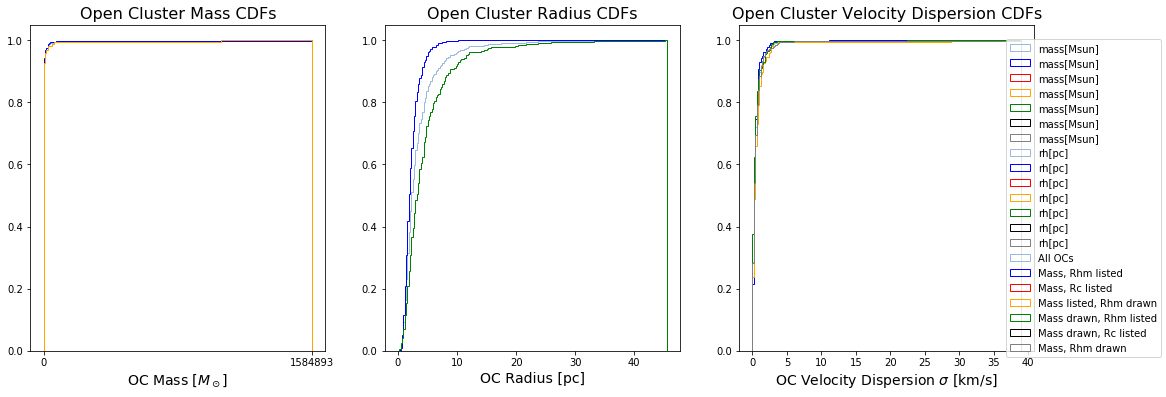

In [141]:
# #################################### OPEN CLUSTERS ############################################

f,axarr = plt.subplots(1,3, figsize = (18,6))
f.subplots_adjust(wspace=0.2, hspace = 0.15)

# OC Mass dist First
axarr[0].hist(OC_Mass, bins = 200, color = '#99badd', histtype = 'step',\
        cumulative = True, fill = False, density = True)
axarr[0].hist(OCm_RH, bins = 200,  color = 'blue', range = (0, np.max(OC_Mass)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(OCm_RC, bins = 200,  color = 'red', range = (0, np.max(OC_Mass)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(OCm_RHstar, bins = 200,  color = 'orange',range = (0, np.max(OC_Mass)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(OCm_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(OC_Mass)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(OCm_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(OC_Mass)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[0].hist(OCm_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(OC_Mass)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
        
axarr[0].set_title('Open Cluster Mass CDFs', fontsize = 16)
axarr[0].set_xlabel('OC Mass [$M_\odot$]', fontsize = 14)
axarr[0].set_xticks([0.,np.max(OC_Mass)])

# OC Radius (middle panel)

axarr[1].hist(OC_Radius, bins = 200, color = '#99badd', range = (0, np.max(OC_Radius)),histtype = 'step',\
        cumulative = True, fill = False, density = True)
axarr[1].hist(OCr_RH, bins = 200,  color = 'blue', range = (0, np.max(OC_Radius)), \
         histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(OCr_RC, bins = 200,  color = 'red', range = (0, np.max(OC_Radius)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(OCr_RHstar, bins = 200,  color = 'orange',range = (0, np.max(OC_Radius)), \
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(OCr_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(OC_Radius)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(OCr_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(OC_Radius)),\
        histtype = 'step', fill = False , cumulative = True, density = True)
axarr[1].hist(OCr_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(OC_Radius)),\
        histtype = 'step', fill = False , cumulative = True, density = True)

axarr[1].set_title('Open Cluster Radius CDFs', fontsize = 16)
axarr[1].set_xlabel('OC Radius [pc]', fontsize = 14)

# OC Sigma

axarr[2].hist(OC_Sigma, bins = 200, color = '#99badd',  range = (0, np.max(OC_Sigma)),\
        label = 'All OCs', histtype = 'step', cumulative = True, fill = False, density = True)
axarr[2].hist(OCsig_RH, bins = 200,  color = 'blue', range = (0, np.max(OC_Sigma)), \
        label = 'Mass, Rhm listed',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(OCsig_RC, bins = 200,  color = 'red', range = (0, np.max(OC_Sigma)), \
        label = 'Mass, Rc listed',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(OCsig_RHstar, bins = 200,  color = 'orange',range = (0, np.max(OC_Sigma)), \
        label = 'Mass listed, Rhm drawn',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(OCsig_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(OC_Sigma)),\
        label = 'Mass drawn, Rhm listed', histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(OCsig_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(OC_Sigma)),\
        label = 'Mass drawn, Rc listed',histtype = 'step', fill = False , cumulative = True, density = True)
axarr[2].hist(OCsig_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(OC_Sigma)),\
        label = 'Mass, Rhm drawn',histtype = 'step', fill = False , cumulative = True, density = True)

axarr[2].set_title('Open Cluster Velocity Dispersion CDFs', fontsize = 16)
axarr[2].set_xlabel('OC Velocity Dispersion $\sigma$ [km/s]', fontsize = 14)

f.legend(loc = 5)
# f.savefig('/Users/andrewbowen/ceb_project/plots/OC-cdfs-density.pdf')

In [142]:
# Function from aaron to make a cumulative distribution we can later draw sigma values from (if they are nans)
def makeCum(x):#x should be an array-like input (in this case )
    if (len(x) > 1):
        n = np.arange(1,len(x)+1) / np.float(len(x))
        xs = np.sort(x)
        return np.insert(xs, 0, min(xs)), np.insert(n, 0, 0.)
    else:
        return [0],[0]

In [143]:
# ####################################### GLOBULAR CLUSTERS #################################################

# made CDFs for all 3 'all' stats: mass, rad, sigma
GC_AllM0, GC_CumMass = makeCum(GC_Mass)
GC_AllR0, GC_CumRadius = makeCum(GC_Radius)
GC_AllSig0, GC_CumSigma = makeCum(GC_Sigma)

# Making CDFs: masses first
GC_MRH0, GC_M_CumMRH = makeCum(GCm_RH)#Mass and rhm good
GC_MRC0, GC_M_CumMRC = makeCum(GCm_RC)#mass and rc good
GC_MRHstar0, GC_M_CumMRHstar = makeCum(GCm_RHstar)#mass good, no radius listed
GC_MstarRH0, GC_M_CumMstar_RH = makeCum(GCm_Mstar_RH)#no mass listed, good rhm
GC_MstarRC0, GC_M_CumMstar_RC = makeCum(GCm_Mstar_RC)#no mass/rhm listed, good rc
GC_MstarRHstar0, GC_M_CumMstar_RHstar = makeCum(GCm_Mstar_RHstar)#whole lotta nothing

# Radius CDFs next
GC_RRH0, GC_R_CumMRH = makeCum(GCr_RH)#Mass and rhm good
GC_RRC0, GC_R_CumMRC = makeCum(GCr_RC)#mass and rc good
GC_RRHstar0, GC_R_CumRRHstar = makeCum(GCr_RHstar)#mass good, no radius listed
GC_RstarRH0, GC_R_CumMstar_RH = makeCum(GCr_Mstar_RH)#no mass listed, good rhm
GC_RstarRC0, GC_R_CumMstar_RC = makeCum(GCr_Mstar_RC)#no mass/rhm listed, good rc
GC_RstarRHstar0, GC_R_CumMstar_RHstar = makeCum(GCr_Mstar_RHstar)#whole lotta nothing

# Sigma CDFS next
sigma_GC_MRH0, GC_sig_CumMRH = makeCum(GCsig_RH)#Mass and rhm good
sigma_GC_MRC0, GC_sig_CumMRC = makeCum(GCsig_RC)#mass and rc good
sigma_GC_MRHstar0, GC_sig_CumMRHstar = makeCum(GCsig_RHstar)#mass good, no radius listed
sigma_GC_MstarRH0, GC_sig_CumMstar_RH = makeCum(GCsig_Mstar_RH)#no mass listed, good rhm
sigma_GC_MstarRC0, GC_sig_CumMstar_RC = makeCum(GCsig_Mstar_RC)#no mass/rhm listed, good rc
sigma_GC_MstarRHstar0, GC_sig_CumMstar_RHstar = makeCum(GCsig_Mstar_RHstar)#whole lotta nothing

In [144]:
# ####################################### OPEN CLUSTERS #################################################

# made CDFs for all 3 'all' stats: mass, rad, sigma
# .loc used to clear out nan values for interpolation


OC_AllM0, OC_CumMass = makeCum(OC_Mass)
OC_AllR0, OC_CumRadius = makeCum(OC_Radius)
OC_AllSig0, OC_CumSigma = makeCum(OC_Sigma)

# Making CDFs: masses first
OC_MRH0, OC_M_CumMRH = makeCum(OCm_RH)#.loc[np.where(OCm_RH != np.nan)])#Mass and rhm good
OC_MRC0, OC_M_CumMRC = makeCum(OCm_RC)#.loc[np.where(OCm_RC != np.nan)])#mass and rc good
OC_MRHstar0, OC_M_CumMRHstar = makeCum(OCm_RHstar)#.loc[np.where(OCm_RH != np.nan)])#mass good, no radius listed
OC_MstarRH0, OC_M_CumMstar_RH = makeCum(OCm_Mstar_RH)#.loc[np.where(OCm_Mstar_RH != np.nan)])#no mass listed, good rhm
OC_MstarRC0, OC_M_CumMstar_RC = makeCum(OCm_Mstar_RC)#.loc[np.where(OCm_Mstar_RC != np.nan)])#no mass/rhm listed, good rc
OC_MstarRHstar0, OC_M_CumMstar_RHstar = makeCum(OCm_Mstar_RHstar)#.loc[np.where(OCm_Mstar_RHstar != np.nan)])#whole lotta nothing

# Radius CDFs next
OC_RRH0, OC_R_CumMRH = makeCum(OCr_RH)#.loc[np.where(OCr_RH != np.nan)])#Mass and rhm good
OC_RRC0, OC_R_CumMRC = makeCum(OCr_RC)#.loc[np.where(OCr_RC != np.nan)])#mass and rc good
OC_RRHstar0, OC_R_CumRRHstar = makeCum(OCr_RHstar)#.loc[np.where(OCr_RHstar != np.nan)])#mass good, no radius listed
OC_RstarRH0, OC_R_CumMstar_RH = makeCum(OCr_Mstar_RH)#.loc[np.where(OCr_MStar_RH != np.nan)])#no mass listed, good rhm
OC_RstarRC0, OC_R_CumMstar_RC = makeCum(OCr_Mstar_RC)#.loc[np.where(OCr_MStar_RC != np.nan)])#no mass/rhm listed, good rc
OC_RstarRHstar0, OC_R_CumMstar_RHstar = makeCum(OCr_Mstar_RHstar)#.loc[np.where(OCr_Mstar_RHstar != np.nan)])#whole lotta nothing

# Sigma CDFS next
sigma_OC_MRH0, OC_sig_CumMRH = makeCum(OCsig_RH)#.loc[np.where(OCsig_RH != np.nan)])#Mass and rhm good
sigma_OC_MRC0, OC_sig_CumMRC = makeCum(OCsig_RC)#.loc[np.where(OCsig_RH != np.nan)])#mass and rc good
sigma_OC_MRHstar0, OC_sig_CumMRHstar = makeCum(OCsig_RHstar)#mass good, no radius listed
sigma_OC_MstarRH0, OC_sig_CumMstar_RH = makeCum(OCsig_Mstar_RH)#.loc[np.where(OCsig_Mstar_RH != np.nan)])#no mass listed, good rhm
sigma_OC_MstarRC0, OC_sig_CumMstar_RC = makeCum(OCsig_Mstar_RC)#.loc[np.where(OCsig_Mstar_RC != np.nan)])#no mass/rhm listed, good rc
sigma_OC_MstarRHstar0, OC_sig_CumMstar_RHstar = makeCum(OCsig_Mstar_RHstar)#.loc[np.where(OCsig_Mstar_RHstar != np.nan)])#whole lotta nothing

In [145]:
# Adding final points to GC distributions (want CDFS to approach same end point)

# Radius appending
GC_RRH0 = np.append(GC_RRH0, np.max(GC_AllM0))
GC_R_CumMRH = np.append(GC_R_CumMRH, 1.)

# Sigma Appending
sigma_GC_MRH0 = np.append(sigma_GC_MRH0, np.max(GC_AllM0))
GC_sig_CumMRH = np.append(GC_sig_CumMRH, 1.)

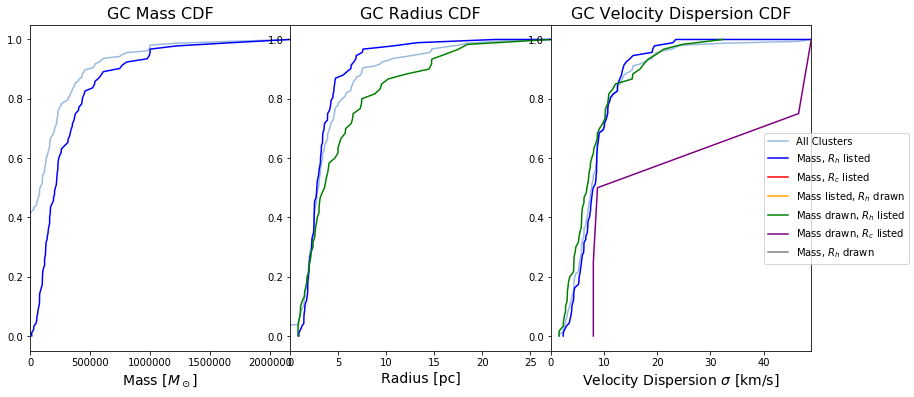

In [146]:
# Using ax.plot (tuples given are x-y values, use those dummy)

f,axarr = plt.subplots(1,3, figsize = (14,6), sharey = 'col')
f.subplots_adjust(wspace=0, hspace = 0)

# GC Mass makeCum CDFs
axarr[0].plot(GC_AllM0, GC_CumMass, color = '#99badd')#All Masses - GCs
axarr[0].plot(GC_MRH0, GC_M_CumMRH, color = 'blue')#Mass , Rhm listed
axarr[0].plot(GC_MRC0, GC_M_CumMRC, color = 'red')#Mass, Rc listed
axarr[0].plot(GC_MRHstar0, GC_M_CumMRHstar, color = 'orange')#Mass listed, Rhm drawn
# axarr[0].plot(GC_MstarRH0, GC_M_CumMstar_RH, color = 'green' )#Mass drawn, Rhm listed
# axarr[0].plot(GC_MstarRC0, GC_M_CumMstar_RC, color = 'purple')#Mass drawn, Rc listed
axarr[0].plot(GC_MstarRHstar0, GC_M_CumMstar_RHstar, color = 'gray')#Mass, Rhm drawn
axarr[0].set_title('GC Mass CDF', fontsize = 16)
axarr[0].set_xlabel('Mass [$M_\odot$]', fontsize = 14)
axarr[0].yaxis.set_tick_params(False)

# GC Radius (middle panel)
axarr[1].plot(GC_AllR0, GC_CumRadius , color = '#99badd')
axarr[1].plot(GC_RRH0, GC_R_CumMRH, color = 'blue')
axarr[1].plot(GC_RRC0, GC_R_CumMRC, color = 'red')
axarr[1].plot(GC_RRHstar0, GC_R_CumRRHstar, color = 'orange')
axarr[1].plot(GC_RstarRH0, GC_R_CumMstar_RH, color = 'green')
axarr[1].plot(GC_RstarRC0, GC_R_CumMstar_RC, color = 'purple')
axarr[1].plot(GC_RstarRHstar0, GC_R_CumMstar_RHstar, color = 'gray')
axarr[1].set_title('GC Radius CDF', fontsize = 16)
axarr[1].set_xlabel('Radius [pc]', fontsize = 14)


# GC Sigma (right panel)
axarr[2].plot(GC_AllSig0, GC_CumSigma, color = '#99badd', label = 'All Clusters')
axarr[2].plot(sigma_GC_MRH0, GC_sig_CumMRH, color = 'blue', label = 'Mass, $R_h$ listed')
axarr[2].plot(sigma_GC_MRC0, GC_sig_CumMRC, color = 'red', label = 'Mass, $R_c$ listed')
axarr[2].plot(sigma_GC_MRHstar0, GC_sig_CumMRHstar, color = 'orange', label = 'Mass listed, $R_h$ drawn')
axarr[2].plot(sigma_GC_MstarRH0, GC_sig_CumMstar_RH, color = 'green', label = 'Mass drawn, $R_h$ listed')
axarr[2].plot(sigma_GC_MstarRC0, GC_sig_CumMstar_RC, color = 'purple', label = 'Mass drawn, $R_c$ listed')
axarr[2].plot(sigma_GC_MstarRHstar0, GC_sig_CumMstar_RHstar, color = 'gray', label = 'Mass, $R_h$ drawn')
axarr[2].set_title('GC Velocity Dispersion CDF', fontsize = 16)
axarr[2].set_xlabel('Velocity Dispersion $\sigma$ [km/s]', fontsize = 14)

# Setting up x and y limits (y from 0 to 1)
axarr[0].set_xlim(0,np.max(GC_AllM0))
axarr[1].set_xlim(0,np.max(GC_AllR0))
axarr[2].set_xlim(0,np.max(GC_AllSig0))

# Adding legend
f.legend(loc = 5)

# f.savefig('/Users/andrewbowen/ceb_project/plots/GC-cdf_makecum.pdf')

In [147]:
GCs['mass[Msun]'].values

array([ 1.00e+06, -9.99e+00,  4.03e+05, -9.99e+00,  2.25e+05, -9.99e+00,
       -9.99e+00, -9.99e+00, -9.99e+00,  3.67e+05,  2.38e+05,  5.72e+04,
        1.00e+06, -9.99e+00, -9.99e+00,  9.75e+05, -9.99e+00, -9.99e+00,
        1.63e+05, -9.99e+00, -9.99e+00,  5.02e+04,  2.23e+05, -9.99e+00,
        1.52e+05,  3.17e+05,  5.21e+05,  8.65e+04,  2.17e+06,  6.10e+05,
        5.36e+05, -9.99e+00,  1.06e+05,  2.04e+05,  2.32e+05, -9.99e+00,
        5.93e+05, -9.99e+00,  1.33e+05,  5.72e+05,  2.28e+05,  1.27e+05,
       -9.99e+00,  4.07e+05, -9.99e+00, -9.99e+00,  3.35e+05,  1.29e+05,
        1.02e+05,  9.40e+04,  3.78e+05, -9.99e+00,  1.21e+05, -9.99e+00,
        4.50e+05,  2.86e+05,  1.44e+05, -9.99e+00,  5.61e+04,  1.68e+05,
       -9.99e+00, -9.99e+00,  8.04e+05,  7.67e+05,  2.61e+05,  1.50e+05,
        2.21e+05,  1.42e+05,  3.71e+05,  3.29e+05,  1.04e+05,  2.59e+05,
        6.33e+04,  4.34e+05, -9.99e+00,  6.62e+04, -9.99e+00, -9.99e+00,
       -9.99e+00, -9.99e+00, -9.99e+00,  1.03e+05, 

In [148]:
# Appending 1 data point to each of these
OC_MRHstar0 = np.append(OC_MRHstar0, np.max(OC_AllM0))#Adding largest cluster mass to these mass arrays
OC_MstarRHstar0 = np.append(OC_MstarRHstar0, np.max(OC_AllM0))
OC_M_CumMRHstar = np.append(OC_M_CumMRHstar, 1.)#Adding a 1 to these cum arrays
OC_M_CumMstar_RHstar = np.append(OC_M_CumMstar_RHstar, 1.)

OC_MRH0 = np.append(OC_MRH0, np.max(OC_AllM0))
OC_M_CumMRH = np.append(OC_M_CumMRH, 1.)

# radii appending

OC_RstarRHstar0 = np.append(OC_RstarRHstar0, np.max(OC_AllR0))
OC_R_CumMstar_RHstar = np.append(OC_R_CumMstar_RHstar, 1.)

# Sigma appending

sigma_OC_MRH0 = np.append(sigma_OC_MRH0, np.max(OC_AllSig0))
OC_sig_CumMRH = np.append(OC_sig_CumMRH, 1.)

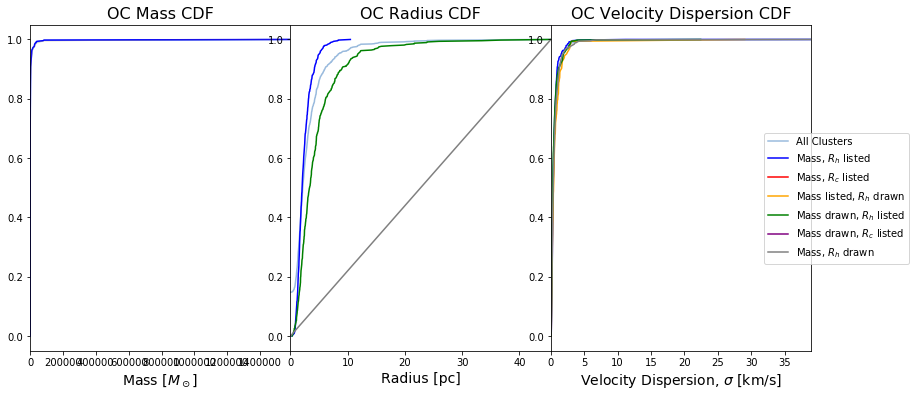

In [149]:
# Open Clusted makeCum plots
# print(OC_MRH0, OC_M_CumMRH)
# Using ax.plot (tuples given are x-y values, use those dummy)

f,axarr = plt.subplots(1,3, figsize = (14,6))
f.subplots_adjust(wspace=0, hspace = 0)

# OC Mass makeCum CDFs
axarr[0].plot(OC_AllM0, OC_CumMass, color = '#99badd')#All Masses - OCs
axarr[0].plot(OC_MRH0, OC_M_CumMRH, color = 'blue')#Mass , Rhm listed
axarr[0].plot(OC_MRC0, OC_M_CumMRC, color = 'red')#Mass, Rc listed
axarr[0].plot(OC_MRHstar0, OC_M_CumMRHstar, color = 'orange', linewidth = 0.5, alpha = 0.2)#Mass listed, Rhm drawn
axarr[0].plot(OC_MstarRH0, OC_M_CumMstar_RH, color = 'green' )#Mass drawn, Rhm listed
axarr[0].plot(OC_MstarRC0, OC_M_CumMstar_RC, color = 'purple')#Mass drawn, Rc listed
# axarr[0].plot(OC_MstarRHstar0, OC_M_CumMstar_RHstar, color = 'gray')#Mass, Rhm drawn
axarr[0].set_title('OC Mass CDF', fontsize = 16)
axarr[0].set_xlabel('Mass [$M_\odot$]', fontsize = 14)
# axarr[0].yaxis.set_tick_params(False, 'y')

# OC Radius (middle panel)
axarr[1].plot(OC_AllR0, OC_CumRadius , color = '#99badd')
axarr[1].plot(OC_RRH0, OC_R_CumMRH, color = 'blue')
axarr[1].plot(OC_RRC0, OC_R_CumMRC, color = 'red')
axarr[1].plot(OC_RRHstar0, OC_R_CumRRHstar, color = 'orange', linewidth = 0.5, alpha = 0.5)
axarr[1].plot(OC_RstarRH0, OC_R_CumMstar_RH, color = 'green')
axarr[1].plot(OC_RstarRC0, OC_R_CumMstar_RC, color = 'purple')
axarr[1].plot(OC_RstarRHstar0, OC_R_CumMstar_RHstar, color = 'gray')
axarr[1].set_title('OC Radius CDF', fontsize = 16)
axarr[1].set_xlabel('Radius [pc]', fontsize = 14)


# OC Sigma (right panel)
axarr[2].plot(OC_AllSig0, OC_CumSigma, color = '#99badd', label = 'All Clusters')
axarr[2].plot(sigma_OC_MRH0, OC_sig_CumMRH, color = 'blue', label = 'Mass, $R_h$ listed')
axarr[2].plot(sigma_OC_MRC0, OC_sig_CumMRC, color = 'red', label = 'Mass, $R_c$ listed')
axarr[2].plot(sigma_OC_MRHstar0, OC_sig_CumMRHstar, color = 'orange', label = 'Mass listed, $R_h$ drawn')
axarr[2].plot(sigma_OC_MstarRH0, OC_sig_CumMstar_RH, color = 'green', label = 'Mass drawn, $R_h$ listed')
axarr[2].plot(sigma_OC_MstarRC0, OC_sig_CumMstar_RC, color = 'purple', label = 'Mass drawn, $R_c$ listed')
axarr[2].plot(sigma_OC_MstarRHstar0, OC_sig_CumMstar_RHstar, color = 'gray', label = 'Mass, $R_h$ drawn')
axarr[2].set_title('OC Velocity Dispersion CDF', fontsize = 16)
axarr[2].set_xlabel('Velocity Dispersion, $\sigma$ [km/s]', fontsize = 14)

# Setting up x and y limits (y from 0 to 1)
axarr[0].set_xlim(0,np.nanmax(OC_AllM0))
axarr[1].set_xlim(0,np.nanmax(OC_AllR0))
axarr[2].set_xlim(0,np.nanmax(OC_AllSig0))
# axarr[0].set_ylim(0.85,)

f.legend(loc = 5)


# f.savefig('/Users/andrewbowen/ceb_project/plots/OC-cdf_makecum.pdf')

In [150]:
def get_age(Age, ClusterDF):
    """
    
    Function that takes in ages of clusters (either Globular or Open) 
    and returns an age if there isn't on, drawing from cum dist
    
    """
#     Checking for good age values first (not NaN and not -9.99)
    if np.isfinite(Age) and Age > 0:
        flag = 'A'
        return Age, flag
    
#     Checking for bad/negative age values
    elif np.isnan(Age) or Age < 0:
        
        
        CumAgeDist = makeCum(ClusterDF['Age'].loc[(np.isfinite(ClusterDF['Age'])) & \
                            (ClusterDF['Age'] > 0)])
        
        y = np.random.random()#random interpolation value from 0 to 1
        DrawnAge = np.interp(y, CumAgeDist[1], CumAgeDist[0])
        flag = 'A*'
        
        return DrawnAge, flag


In [151]:
# OC Age loop

# OCs first
OC_Age = []
OC_AgeFlags = []

for index, row in OCs.iterrows():
    
    Age, flag = get_age(row['Age'], OCs)
    
    OC_Age.append(Age)
    OC_AgeFlags.append(flag)
    
# GC Age Loop
GC_Age = []
GC_AgeFlags = []

for index, row in GCs.iterrows():
    
    Age, flag = get_age(row['Age'], GCs)
    
    GC_Age.append(Age)
    GC_AgeFlags.append(flag)
    
print(GC_Age)

[12344.0, 9757.0, 9522.0, 9522.0, 9287.0, 6466.0, 11488.093009321597, 13104.2371485853, 11685.756427738206, 8817.0, 11168.0, 11638.0, 10031.83725057503, 11521.0, 8880.615632854027, 9993.0, 11991.0, 10784.215826382015, 9522.0, 11112.334119097872, 11638.0, 10463.0, 12061.62838351629, 12354.563368588157, 10698.0, 11521.0, 11638.0, 11286.0, 10463.0, 10463.0, 11521.0, 11638.0, 12579.0, 11991.0, 11638.0, 10436.33362685662, 11254.35252901577, 9522.0, 11168.0, 9757.0, 11874.0, 10227.244509372236, 11752.15018089542, 11168.0, 13990.0, 9522.0, 11521.0, 11521.0, 11521.0, 12579.0, 11168.0, 12937.74647781754, 13284.0, 10399.062550750443, 10580.0, 11521.0, 11638.0, 5996.0, 12344.0, 10345.0, 11638.0, 11168.0, 11538.255530061706, 10463.0, 11232.830000292834, 11654.631548988593, 10463.0, 12814.0, 9483.195474747685, 12109.000000000002, 12261.799797669137, 12334.913987811322, 13808.455450699541, 7310.443570182092, 11638.0, 11991.0, 11874.0, 9993.0, 12579.0, 11521.0, 11874.0, 12579.0, 11225.783457044581, 1

In [152]:
# Putting age values in our DFs

OCs['Age'] = pd.Series(OC_Age)
GCs['Age'] = pd.Series(GC_Age)

# Adding flag lists too
OCs['Age flag'] = pd.Series(OC_AgeFlags)
GCs['Age flag'] = pd.Series(GC_AgeFlags)

In [153]:
# GCs

In [154]:
# Metallicity function
def get_Z(Z, ClusterDF):
    """
    
    Function that takes in metallicities of clusters (either Globular or Open) 
    and returns an metallicit if there isn't on, drawing from cum dist of good metallicities
    
    """
#     Checking for good age values first (not NaN and not -9.99)
    if np.isfinite(Z) and Z != 99.999:
        flag = 'Z'
        return Z, flag
    
#     Checking for bad/negative age values
    elif np.isnan(Z) or Z == 99.999:
        
        
        CumZDist = makeCum(ClusterDF['Z'].loc[(np.isfinite(ClusterDF['Z'])) & \
                            (ClusterDF['Z'] != 99.999)])
        
        y = np.random.random()#random interpolation value from 0 to 1
        DrawnZ = np.interp(y, CumZDist[1], CumZDist[0])
        flag = 'Z*'

        return DrawnZ, flag

In [155]:
# Metallicity Loop - Open Clusters
OC_Z = []
OC_Zflag = []

for index, row in OCs.iterrows():
    
#     Running function
    OCZ, flag = get_Z(row['Z'], OCs)
    
#    Appending to lists, will put into OC df later 
    OC_Z.append(OCZ)
    OC_Zflag.append(flag)

# Globular Clusters loop
GC_Z = []
GC_Zflag = []

for index, row in GCs.iterrows():
    
#     Running function
    GCZ, flag = get_Z(row['Z'], GCs)
    
#    Appending to lists, will put into OC df later 
    GC_Z.append(GCZ)
    GC_Zflag.append(flag)

In [156]:
# GCs

In [157]:
# Putting Metallicity calc values into our DF
OCs['Z'] = pd.Series(OC_Z)
GCs['Z'] = pd.Series(GC_Z)

# Adding flags
OCs['Z flag'] = pd.Series(OC_Zflag)
GCs['Z flag'] = pd.Series(GC_Zflag)

In [158]:
# Distance function
# Metallicity function
def get_dist(dist, ClusterDF):
    """
    
    Function that takes in distancec of clusters (either Globular or Open) 
    and returns a dist if there isn't on, drawing from cum dist
    
    """
#     Checking for good age values first (not NaN and not -9.99)
    if np.isfinite(dist) and dist > 0:
        flag = 'd'
        return dist, flag
    
#     Checking for bad/negative age values
    elif np.isnan(dist) or dist < 0:
        
        
        CumDistance = makeCum(ClusterDF['dist[kpc]'].loc[(np.isfinite(ClusterDF['dist[kpc]'])) & \
                            (ClusterDF['dist[kpc]'] > 0 )])
        
        y = np.random.random()#random interpolation value from 0 to 1
        DrawnDist = np.interp(y, CumDistance[1], CumDistance[0])
        flag = 'd*'
#         print(dist, DrawnDist)

        return DrawnDist, flag

In [159]:
# Distance for loops

# Open cluster loop
OC_Dist = []
OC_DistFlag = []

for index, row in OCs.iterrows():
    
#     Running function
    OCdist, flag = get_dist(row['dist[kpc]'], OCs)
    
#    Appending to lists, will put into OC df later 
    OC_Dist.append(OCdist)
    OC_DistFlag.append(flag)

# Globular Clusters loop
GC_Dist = []
GC_DistFlag = []

for index, row in GCs.iterrows():
    
#     Running function
    GCdist, flag = get_dist(row['dist[kpc]'], GCs)
    
#    Appending to lists, will put into OC df later 
    GC_Dist.append(GCdist)
    GC_DistFlag.append(flag)
    


In [160]:
# Putting Distance calc values into our DF
OCs['dist[kpc]'] = pd.Series(OC_Dist)
GCs['dist[kpc]'] = pd.Series(GC_Dist)

# Adding flags
OCs['dist flag'] = pd.Series(GC_DistFlag)
GCs['dist flag'] = pd.Series(GC_DistFlag)

In [161]:
# Recreating Clusters dataframe with updated OC/GC sigma values
# Concatenating our OC and GC dataframes into one big dataframe (will make a a csv file later)
Clusters = pd.concat([OCs,GCs], axis = 0, join = 'outer')
# print(Clusters.columns)
# Reorganizing all cluster dataframe column order
ClusterCols = Clusters.columns
ClusterCols = ['Name', 'RA', 'Dec', 'dist[kpc]', 'rh[pc]', 'r_c','mass[Msun]', \
               'Age', 'Z', 'sigma_v[km/s]', 'sigma_source','OpSim ID','OpSim RA','OpSim Dec',\
              'Source Flag', 'Cluster Type','dist flag', 'Age flag', 'Z flag']
Clusters = Clusters[ClusterCols]

Clusters

/Users/andrewbowen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


,Name,RA,Dec,dist[kpc],rh[pc],r_c,mass[Msun],Age,Z,sigma_v[km/s],sigma_source,OpSim ID,OpSim RA,OpSim Dec,Source Flag,Cluster Type,dist flag,Age flag,Z flag
0,Alessi_4,10 16 13,-34 21 00,0.690000,NaN,NaN,NaN,7749.764463,0.060000,0.777587,m*rh*,1158.0,154d12m30.3113s,-34d07m12.7652s,W,O,d,A*,Z*
1,Alessi_11,20 21 24,+18 21 36,2.042532,NaN,NaN,NaN,8741.704231,0.000000,4.067033,m*rh*,3503.0,304d10m28.5278s,18d59m17.4486s,W,O,d,A*,Z*
2,Alessi_14,06 30 27,+09 44 28,1.504839,NaN,NaN,NaN,8590.000000,-0.295220,0.091417,m*rh*,3076.0,97d14m05.5078s,9d29m26.8453s,W,O,d,A*,Z*
3,Alessi_15,06 43 04,+01 40 19,0.925259,NaN,NaN,NaN,9150.934353,0.322100,1.440343,m*rh*,2744.0,101d43m21.2329s,2d08m27.643s,W,O,d,A*,Z*
4,Alessi_16,06 43 35,+02 10 24,1.500000,NaN,NaN,NaN,9500.000000,-0.165666,0.285283,m*rh*,2744.0,101d43m21.2329s,2d08m27.643s,W,O,d,A*,Z*
5,Alessi_17,07 35 24,-15 05 30,1.539238,NaN,NaN,NaN,7000.000000,-0.729003,1.659200,m*rh*,1958.0,112d57m57.2827s,-14d59m34.1341s,W,O,d,A*,Z*
6,AM_0430-392,04 32 24,-39 17 36,2.345504,NaN,NaN,NaN,8490.679214,-0.580000,0.132197,m*rh*,933.0,68d17m27.1619s,-40d00m22.4121s,W,O,d,A*,Z*
7,AM_1353-265,13 56 21,-27 10 00,3.161312,NaN,NaN,NaN,8950.000000,-0.160000,0.073828,m*rh*,1495.0,208d09m24.6973s,-25d52m51.6911s,W,O,d,A*,Z*
8,Andrews-Lindsay5,18 44 19,-04 55 48,7.275767,NaN,NaN,NaN,7500.000000,-0.514928,0.181886,m*rh*,2445.0,280d12m35.3101s,-4d34m36.8297s,W,O,d,A*,Z*
9,Antalova_2,17 29 42,-32 32 00,1.626587,NaN,NaN,NaN,7399.000237,0.000000,0.375901,m*rh*,1233.0,261d27m51.46s,-31d51m01.4227s,W,O,d,A*,Z*


In [162]:
# Reordering Columns
ClusterCols = ['Name', 'RA', 'Dec', 'dist[kpc]', 'rh[pc]', 'r_c', 'mass[Msun]', 'Age',\
        'Z', 'sigma_v[km/s]', 'sigma_source','OpSim ID', 'OpSim RA', 'OpSim Dec',\
       'Source Flag', 'Cluster Type', 'dist flag', 'Age flag', 'Z flag']
Clusters = Clusters[ClusterCols]


In [163]:
# Converting All Clusters RA/Dec into degrees (w/ lots of decimal places)

# 
ClusterRA = Angle(Clusters['RA'], u.hour)#RA in hours, minutes, seconds
ClusterDec = Angle(Clusters['Dec'], u.degree)#Dec listed in degrees

# Setting the arrays as degrees
ClusterRA = ClusterRA.degree
ClusterDec = ClusterDec.degree

print(ClusterRA)
print(ClusterDec)

Clusters['RA'] = ClusterRA
Clusters['Dec'] = ClusterDec

[154.05416667 305.35        97.6125     ... 326.66183333 346.68516667
 347.11095833]
[-34.35        18.36         9.74111111 ... -21.25261111  12.772
 -15.6115    ]


In [164]:
# print(Clusters['Age'].to_string(), Clusters['Z'].to_string())
# Ages are good, let's fix metallicities

Clusters['Z'].loc[Clusters['Z'] > 2] = np.random.uniform(-0.2,0.2)


/Users/andrewbowen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [165]:
# Converting OpSim Coords to floats
OPS_RA = []
OPS_Dec = []
n = 0
for index, row in Clusters.iterrows():
    

    
    n += 1
    ORA = row['OpSim RA']

    ODEC = row['OpSim Dec']
    
    ORA = ORA.degree#.wrap_at(180)
    
#     Converting to strings first
#     ORA = ORA.to_string(unit = u.degree, decimal = True)
    ODEC = ODEC.to_string(unit = u.degree, decimal = True)
    print(n, ORA, ODEC)
#     Converting to floats
    FORA = float(ORA)
    FODEC = float(ODEC)
    
#     Putting floats in those young lists
    OPS_RA.append(FORA)
    OPS_Dec.append(FODEC)
    

1 154.208419799805 -34.1202
2 304.174591064453 18.9882
3 97.23486328125 9.49079
4 101.72256469726601 2.14101
5 101.72256469726601 2.14101
6 112.96591186523399 -14.9928
7 68.2908782958984 -40.0062
8 208.15686035156202 -25.881
9 280.209808349609 -4.5769
10 261.46429443359403 -31.8504
11 283.18853759765597 5.2086
12 311.635009765625 45.0191
13 324.000030517578 50.8729
14 169.06591796875 -59.2422
15 100.107894897461 -0.449605
16 107.999984741211 2.3081
17 109.56011962890601 4.80938
18 299.78277587890597 29.4076
19 304.36444091796903 46.8794
20 321.016082763672 58.5893
21 120.63777160644501 -32.4591
22 131.34982299804702 -52.9718
23 132.918273925781 -39.6391
24 138.503524780273 -55.9783
25 139.272171020508 -50.8012
26 141.45388793945298 -53.4706
27 144.00003051757798 -50.8729
28 144.00003051757798 -56.0711
29 144.00003051757798 -56.0711
30 146.546142578125 -53.4706
31 152.918441772461 -58.3803
32 150.61276245117202 -48.0753
33 149.49645996093798 -55.9783
34 153.433731079102 -50.5834
35 154.

378 205.386444091797 -63.321
379 208.174163818359 -65.9281
380 209.511260986328 -61.011
381 209.511260986328 -61.011
382 209.511260986328 -61.011
383 207.08155822753898 -58.3803
384 213.016021728516 -58.5892
385 213.016021728516 -58.5892
386 213.016021728516 -58.5892
387 216.000045776367 -61.1269
388 219.558944702148 -63.5784
389 219.558944702148 -63.5784
390 218.983917236328 -58.5893
391 222.488723754883 -61.011
392 224.91847229003898 -58.3803
393 226.946197509766 -55.6972
394 230.754089355469 -57.9581
395 230.754089355469 -57.9581
396 230.754089355469 -57.9581
397 232.303146362305 -55.2215
398 236.429611206055 -57.3166
399 243.13606262207 -50.8599
400 243.612976074219 -48.0666
401 252.0 -42.8712
402 173.671035766602 -63.7821
403 296.71478271484403 28.7786
404 62.5700912475586 53.6561
405 113.010353088379 -19.986
406 141.45388793945298 -53.4706
407 123.538154602051 -44.0648
408 133.004577636719 -47.8192
409 9.18877601623535 72.0997
410 13.3886184692383 35.4417
411 14.450385093689 11.0

696 131.34982299804702 -52.9718
697 289.524169921875 -15.2076
698 51.3407211303711 47.4244
699 130.92639160156202 18.5368
700 115.309226989746 -39.7069
701 264.132781982422 -46.1698
702 72.00010681152341 70.9152
703 138.14665222168 -42.6898
704 19.1271686553955 33.448
705 208.174163818359 -65.9281
706 207.08155822753898 -58.3803
707 269.10882568359403 3.86375
708 340.30316162109403 55.2214
709 0.0 -28.9318
710 93.4259490966797 -21.43
711 75.3412246704102 22.2673
712 281.907348632812 -17.7388
713 267.62982177734403 1.46412
714 107.999969482422 -45.6499
715 268.77069091796903 -35.9668
716 115.01584625244101 -36.9101
717 33.016017913818395 58.5892
718 80.20518493652341 15.3901
719 107.999984741211 -37.3454
720 292.96185302734403 25.0188
721 321.793060302734 48.2011
722 93.9990386962891 4.12674
723 81.4028091430664 -1.95313
724 284.626373291016 33.1466
725 287.999969482422 37.3454
726 346.803558349609 64.7826
727 267.474761962891 6.5381
728 96.8486175537109 -5.69005
729 149.49645996093798 

1038 107.99999237060499 -17.0806
1039 122.89208221435499 -29.9663
1040 186.328964233398 -63.7821
1041 216.000045776367 -61.1269
1042 252.000061035156 -51.2427
1043 272.64874267578097 -22.3381
1044 283.385864257812 -9.85417
1045 292.96185302734403 25.0188
1046 316.38226318359403 14.9608
1047 243.13606262207 -50.8599
1048 268.77069091796903 -35.9668
1049 247.887420654297 -46.9632
1050 255.620269775391 -38.6541
1051 247.405624389648 -52.5554
1052 223.622268676758 -53.306
1053 255.92463684082 -44.1828
1054 124.77069091796899 -35.9668
1055 117.82461547851601 -23.3007
1056 115.964218139648 -25.6983
1057 131.34982299804702 -52.9718
1058 186.328964233398 -63.7821
1059 91.2062454223633 14.1124
1060 106.36608123779301 -9.93041
1061 110.60220336914101 -27.2927
1062 82.04222106933591 34.8201
1063 66.71224975585939 58.1732
1064 283.113372802734 10.097
1065 259.015899658203 -36.91
1066 252.000030517578 -45.6499
1067 82.04222106933591 34.8201
1068 121.563194274902 -51.7583
1069 149.49645996093798 -55

1357 13.1964435577393 64.7826
1358 23.114402770996104 60.661
1359 33.016017913818395 58.5892
1360 98.5971908569336 1.95313
1361 29.5112571716309 61.011
1362 200.52038574218798 -65.4998
1363 348.05538940429705 62.0212
1364 78.6268844604492 17.6965
1365 190.93408203125 -59.2422
1366 146.546142578125 -53.4706
1367 201.24586486816398 -57.9581
1368 159.47961425781202 -65.4998
1369 169.06591796875 -59.2422
1370 262.042205810547 -34.8201
1371 27.081556320190398 58.3803
1372 80.7148056030273 28.7786
1373 168.05538940429702 -62.0212
1374 103.188545227051 -5.2086
1375 297.824615478516 23.3007
1376 247.887420654297 -46.9632
1377 213.016021728516 -58.5892
1378 42.488716125488295 61.011
1379 111.341201782227 -22.2673
1380 230.754089355469 -57.9581
1381 130.439758300781 -33.8247
1382 144.00003051757798 -56.0711
1383 300.637786865234 32.4591
1384 158.754135131836 -57.9581
1385 116.32434844970699 -20.4117
1386 129.23953247070298 -30.8642
1387 301.388549804688 35.4417
1388 90.9111557006836 24.8893
1389

1699 118.946990966797 -26.3415
1700 44.9184722900391 58.3803
1701 118.946990966797 -26.3415
1702 252.000030517578 -45.6499
1703 5.752985000610349 60.9812
1704 5.752985000610349 60.9812
1705 302.791717529297 41.2282
1706 115.964218139648 -25.6983
1707 75.9246292114258 44.1828
1708 278.82415771484403 -12.2103
1709 327.55889892578097 63.5784
1710 10.934079170227099 59.2422
1711 131.634994506836 -45.0191
1712 130.439758300781 -33.8247
1713 79.97930908203121 45.2779
1714 104.902633666992 7.32371
1715 163.103424072266 -60.0723
1716 124.77069091796899 -35.9668
1717 259.309204101562 -39.7069
1718 259.015899658203 -36.91
1719 158.754135131836 -57.9581
1720 72.00006103515621 51.2427
1721 118.946990966797 -26.3415
1722 113.67650604248001 -28.079
1723 108.000015258789 -12.307
1724 186.328964233398 -63.7821
1725 25.3864364624023 63.321
1726 112.88658905029301 -10.097
1727 112.96591186523399 -14.9928
1728 100.107894897461 -0.449605
1729 140.290878295898 -40.0062
1730 87.8589019775391 32.992
1731 98.

In [166]:
# appending correct unit stuff to df
Clusters['OpSim RA'] = pd.Series(OPS_RA)
Clusters['OpSim Dec'] = pd.Series(OPS_Dec)

In [167]:
# Saving updated dataframe to a csv file containing all data/flags on every custer we have

Clusters.to_csv('/Users/andrewbowen/ceb_project/data/all-clusters.csv', \
                sep = ',', header = ClusterCols)
# File should be good to go to run through everything


In [168]:
GCs.columns = ClusterCols
# OCs.columns = ClusterCols
print(Clusters.columns)
print(GCs.columns)

Index(['Name', 'RA', 'Dec', 'dist[kpc]', 'rh[pc]', 'r_c', 'mass[Msun]', 'Age',
       'Z', 'sigma_v[km/s]', 'sigma_source', 'OpSim ID', 'OpSim RA',
       'OpSim Dec', 'Source Flag', 'Cluster Type', 'dist flag', 'Age flag',
       'Z flag'],
      dtype='object')
Index(['Name', 'RA', 'Dec', 'dist[kpc]', 'rh[pc]', 'r_c', 'mass[Msun]', 'Age',
       'Z', 'sigma_v[km/s]', 'sigma_source', 'OpSim ID', 'OpSim RA',
       'OpSim Dec', 'Source Flag', 'Cluster Type', 'dist flag', 'Age flag',
       'Z flag'],
      dtype='object')


In [170]:
GCs

,Name,RA,Dec,dist[kpc],rh[pc],r_c,mass[Msun],Age,Z,sigma_v[km/s],sigma_source,OpSim ID,OpSim RA,OpSim Dec,Source Flag,Cluster Type,dist flag,Age flag,Z flag
0,NGC 104,00 24 05.67,-72 04 52.6,4.5,-0.720000,4.150,0.471239,1000000.00,12344.000000,11.00,141.0,0d00m00s,-70d55m59.1522s,G,14.148381,rh,A,Z,d
1,NGC 288,00 52 45.24,-26 34 57.4,8.9,-1.320000,5.773,3.495022,-9.99,9757.000000,2.90,1474.0,1d34m23.5273s,-26d08m26.0097s,G,4.329066,m*rh,A,Z,d
2,NGC 362,01 03 14.26,-70 50 55.6,8.6,-1.260000,2.051,0.450295,403000.00,9522.000000,6.40,141.0,0d00m00s,-70d55m59.1522s,G,12.776164,rh,A,Z,d
3,Whiting 1,02 02 57,-03 15 10,30.1,-0.700000,1.926,2.188934,-9.99,9522.000000,-9.99,2544.0,3d08m31.2076s,-2d15m52.8837s,G,10.682278,m*rh,A*,Z,d
4,NGC 1261,03 12 16.21,-55 12 58.4,16.3,-1.270000,3.224,1.659517,225000.00,9287.000000,-9.99,448.0,5d29m47.285s,-55d58m41.9696s,G,7.614204,rh,A,Z,d
5,Pal 1,03 33 20.04,+79 34 51.8,11.1,-0.650000,1.485,0.032289,-9.99,6466.000000,-9.99,5246.0,0d00m00s,79d13m10.7959s,G,15.412810,m*rh,A,Z,d
6,AM 1,03 55 02.3,-49 36 55,123.3,-1.700000,14.705,6.097308,-9.99,11488.093009,-9.99,601.0,4d43m40.126s,-50d48m04.2957s,G,3.090802,m*rh,A*,Z,d
7,Eridanus,04 24 44.5,-21 11 13,90.1,-1.430000,12.056,6.552257,-9.99,13104.237149,-9.99,1716.0,4d35m28.4534s,-20d32m07.0226s,G,7.393871,m*rh,A*,Z,d
8,Pal 2,04 46 05.91,+31 22 53.4,27.2,-1.420000,3.956,1.345067,-9.99,11685.756428,-9.99,4011.0,6d20m00.8657s,31d09m42.7904s,G,5.947048,m*rh,A*,Z,d
9,NGC_1851,05 14 06.76,-40 02 47.6,12.1,-1.180000,1.795,0.316777,367000.00,8817.000000,10.40,941.0,3d42m32.875s,-40d00m22.1649s,G,13.032616,rh,A,Z,d


In [171]:
OCs

,Name,RA,Dec,dist[kpc],rh[pc],mass[Msun],Age,Z,OpSim ID,OpSim RA,OpSim Dec,Source Flag,Cluster Type,sigma_v[km/s],sigma_source,Age flag,Z flag,dist flag
0,Alessi_4,10 16 13,-34 21 00,0.690000,NaN,NaN,7749.764463,0.060000,1158.0,154d12m30.3113s,-34d07m12.7652s,W,O,0.777587,m*rh*,A*,Z*,d
1,Alessi_11,20 21 24,+18 21 36,2.042532,NaN,NaN,8741.704231,0.000000,3503.0,304d10m28.5278s,18d59m17.4486s,W,O,4.067033,m*rh*,A*,Z*,d
2,Alessi_14,06 30 27,+09 44 28,1.504839,NaN,NaN,8590.000000,-0.295220,3076.0,97d14m05.5078s,9d29m26.8453s,W,O,0.091417,m*rh*,A*,Z*,d
3,Alessi_15,06 43 04,+01 40 19,0.925259,NaN,NaN,9150.934353,0.322100,2744.0,101d43m21.2329s,2d08m27.643s,W,O,1.440343,m*rh*,A*,Z*,d
4,Alessi_16,06 43 35,+02 10 24,1.500000,NaN,NaN,9500.000000,-0.165666,2744.0,101d43m21.2329s,2d08m27.643s,W,O,0.285283,m*rh*,A*,Z*,d
5,Alessi_17,07 35 24,-15 05 30,1.539238,NaN,NaN,7000.000000,-0.729003,1958.0,112d57m57.2827s,-14d59m34.1341s,W,O,1.659200,m*rh*,A*,Z*,d
6,AM_0430-392,04 32 24,-39 17 36,2.345504,NaN,NaN,8490.679214,-0.580000,933.0,68d17m27.1619s,-40d00m22.4121s,W,O,0.132197,m*rh*,A*,Z*,d
7,AM_1353-265,13 56 21,-27 10 00,3.161312,NaN,NaN,8950.000000,-0.160000,1495.0,208d09m24.6973s,-25d52m51.6911s,W,O,0.073828,m*rh*,A*,Z*,d
8,Andrews-Lindsay5,18 44 19,-04 55 48,7.275767,NaN,NaN,7500.000000,-0.514928,2445.0,280d12m35.3101s,-4d34m36.8297s,W,O,0.181886,m*rh*,A*,Z*,d
9,Antalova_2,17 29 42,-32 32 00,1.626587,NaN,NaN,7399.000237,0.000000,1233.0,261d27m51.46s,-31d51m01.4227s,W,O,0.375901,m*rh*,A*,Z*,d


In [176]:
# New OC/GC cleaned files
gcHeader = ['Name', 'RA', 'Dec', 'dist[kpc]', 'rh[pc]', 'r_c', 'mass[Msun]', 'Age',
       'Z', 'sigma_v[km/s]', 'sigma_source', 'OpSim ID', 'OpSim RA',
       'OpSim Dec', 'Source Flag', 'Cluster Type', 'dist flag', 'Age flag',
       'Z flag']
ocHeader = ['Name', 'RA', 'Dec', 'dist[kpc]', 'rh[pc]', 'mass[Msun]', 'Age', 'Z',
       'OpSim ID', 'OpSim RA', 'OpSim Dec', 'Source Flag', 'Cluster Type',
       'sigma_v[km/s]', 'sigma_source', 'Age flag', 'Z flag', 'dist flag']
OCs.to_csv('/Users/andrewbowen/ceb_project/data/OC_data/oc-data-cleaned.csv', \
                sep = ',', header = ocHeader)
GCs.to_csv('/Users/andrewbowen/ceb_project/data/GC_data/gc-data-cleaned.csv', \
                sep = ',', header = gcHeader)

In [ ]:
# New Function: from pseudo code above

# def get_sigma(Rh, Rc, M):
#     '''
#     new function to improve on our get_sigma from above
#     '''
    
#     G = 1.334 * (10 ** 11)#Gravitational constant in km^3 M_sun ^ -1 s ^ -2 (consistent with cosmic output units)
#     const = (3 * np.pi * G) /64
    
    
# #     Checking for mass value existence first
#     if M > 0 and not np.isnan(M):
# #         Checking for half-mass radius first
#         if np.isfinite(Rh) and Rh > 0:#best case scenario
#             Rh = Rh * (3.086 * (10**13)) #converting to pc from km
#             a = Rh / 1.305 
#             sigma_rh = np.sqrt(const * M/a)    
#             flag = 'rh'

#             return sigma_rh, flag
        
# #         If there is a mass but no Rhm listed, check for core radius
#         elif np.isfinite(Rc)and Rc > 0:
#             Rc = Rc * (3.086 * (10**13)) #converting to pc from km
#             a = np.sqrt(2) * Rc
#             sigma_rc = np.sqrt(const * M/a)
#             flag = 'rc'

#             return sigma_rc, flag
            
# #         If there is a mass but no Rc or Rh, draw an Rh randomly
#         else:#picking out good rhm values to draw from

# #             Making a cumulative distribution of all good able half-mass radii
#             CumRhDist = makeCum(Clusters['rh[pc]'].loc[(Clusters['rh[pc]'] != np.nan) & \
#                             (Clusters['rh[pc]'] >0)])
# #           Drawing from the distribution created above, and converting to km from pc
#             y = np.random.random()#random y value to use as interpolation pt
#             DrawnRh = np.interp(y, CumRhDist[1], CumRhDist[0])  * (3.086 * (10**13))

#             a = DrawnRh / 1.305
#             sigma_rhD = np.sqrt(const * M/a)#rhD for half-mass radius 'Drawn'
#             flag = 'rh*'#star indicates that value is drawn from dist
#             return sigma_rhD, flag
        
# #     if there is not a mass given
#     elif np.isnan(M) or M < 0:
        
# #         Drawing a random mass, can change distribution later
#         CumMassDist = makeCum(Clusters['mass[Msun]'].loc[(Clusters['mass[Msun]'] != np.nan) &\
#                                 (Clusters['mass[Msun]'] >0)])#Drawing a random mass from a cumulative distribution of cluster masses
    
# #       Choosing randomly from our cumulative distribution of cluster masses
#         y = np.random.random()#Random value from 0 to 1 as interpolation pt
# #         drawnMass = np.random.choice(CumMassDist)
#         drawnMass = np.interp(y, CumMassDist[1], CumMassDist[0])
        
        
# #         if there is a half-mass radius listed but no mass 
#         if np.isfinite(Rh) and Rh > 0:
#             Rh = Rh * (3.086 * (10**13)) #converting given half-mas radius to pc from km
#             a = Rh / 1.305
#             sigma_rh_MD = np.sqrt(const * drawnMass/a)    
#             flag = 'm*rh'
#             return sigma_rh_MD, flag
        
# #         if there is a core-radius value listed (but no mass)
#         elif np.isfinite(Rc) and Rc > 0:
#             Rc = Rc * (3.086 * (10**13)) #converting given core radius to pc from km
#             a = np.sqrt(2) * Rc
#             sigma_rc_MD = np.sqrt(const * drawnMass/a)
#             flag = 'm*rc'
#             return sigma_rc_MD, flag
            
# #         If there is a mass but no Rc or Rh, draw a Rh randomly - can change dist shape later (want cumulative of present good rhms)

#         else:#This is the worst of all timelines

# #             Making a cumulative distribution of all good able half-mass radii
#             CumRhDist = makeCum(Clusters['rh[pc]'].loc[(Clusters['rh[pc]'] != np.nan) & \
#                             (Clusters['rh[pc]'] > 0)])
    
# #             drawing random half-mass radius from dristribution above and feeding to Plummer model
#             DrawnRh = np.interp(y, CumRhDist[1], CumRhDist[0])  * (3.086 * (10**13))
    
#             a = (DrawnRh / 1.305)
#             sigma_crh_MD = np.sqrt(const * drawnMass/a)
#             flag = 'm*rh*'

#             return sigma_crh_MD, flag



In [ ]:
# looping through and applying our get_sigma function to every cluster, hope there's enough data

# Lists to append stuff to later
# ClusterSigma = []
# SigmaSource = []
# n = 0

# # Looping through every cluster (OC & GC) in our Clusters DF
# for index, cluster in Clusters.iterrows():
    
# #     Setting up function inputs (half-mass radius, )
#     R_HalfMass = cluster['rh[pc]']
#     R_Core = cluster['r_c']
#     Mcl = cluster['mass[Msun]']
    
# #     Running get_sigma function on clusters
#     sigma, flag = get_sigma(R_HalfMass, R_Core, Mcl)
    
# #     Appending values and flags to lists
#     ClusterSigma.append(sigma)
#     SigmaSource.append(flag)
#     n += 1

    
# print(np.max(ClusterSigma), np.argmax(ClusterSigma))
# print(ClusterSigma)

In [ ]:
# # Histogram of cluster velocity dispersions - will draw from (cumulative) distribution to feed 
# f,ax = plt.subplots(figsize = (8,5))
# ax.hist(Clusters['sigma_v[km/s]'], bins = 300, range = (0, np.max(Clusters['sigma_v[km/s]'])),color = '#99badd')
# ax.set_xlabel('Velocity Dispersion, $\sigma$ [km/s]')
# # ax.set_xlim(0.,5)

## Cumulative plot of velocity dispersions - from meeting with Aaron
# f,ax = plt.subplots(figsize = (8,5))
# ax.hist(Clusters['sigma_v[km/s]'], bins = 150, range = (0, np.max(Clusters['sigma_v[km/s]'])),color = '#99badd', cumulative = True)
# ax.set_xlabel('Velocity Dispersion, $\sigma$ [km/s]')
# ax.set_title('Cumulative plot: velocity dispersion $\sigma$')
# ax.set_xlim(0.,18)

In [ ]:
# Now making plots of different CDFs for each flag

#list of flags we used in loop, star indicates the value was drawn randomly from cdf
# sigma_flags = ['rh', 'rc', 'rh*','m*rh', 'm*rc', 'm*rh*']

# # Mass distributions first - grouping cluster masses by which flag we used to get sigma
# m_RH = Clusters['mass[Msun]'].loc[Clusters['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
# m_RC = Clusters['mass[Msun]'].loc[Clusters['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
# m_RHstar = Clusters['mass[Msun]'].loc[Clusters['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
# m_Mstar_RH = Clusters['mass[Msun]'].loc[Clusters['sigma_source'] == 'm*rh']#No mass but an rhm
# m_Mstar_RC = Clusters['mass[Msun]'].loc[Clusters['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
# m_Mstar_RHstar = Clusters['mass[Msun]'].loc[Clusters['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

# # All masses 
# Mcl = Clusters['mass[Msun]']

# # Now radii distributions - - grouping cluster radii by which flag we used to get sigma
# r_RH = Clusters['rh[pc]'].loc[Clusters['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
# r_RC = Clusters['rh[pc]'].loc[Clusters['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
# r_RHstar = Clusters['rh[pc]'].loc[Clusters['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
# r_Mstar_RH = Clusters['rh[pc]'].loc[Clusters['sigma_source'] == 'm*rh']#No mass but an rhm
# r_Mstar_RC = Clusters['rh[pc]'].loc[Clusters['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
# r_Mstar_RHstar = Clusters['rh[pc]'].loc[Clusters['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

# # All radii
# Rcl = Clusters['rh[pc]']


In [ ]:
# Mass CDF plots
# all_mass = Clusters['mass[Msun]']#setting up variable that contains series/column of all cluster  masses

# f,ax = plt.subplots(figsize = (8,5))
# ax.hist(all_mass, bins = 150, color = '#99badd', histtype = 'step',\
#         label = 'All Clusters',cumulative = True, fill = False, density = True)
# ax.hist(m_RH, bins = 150,  color = 'blue', range = (0, np.max(all_mass)), \
#         label = 'Mass, Rhm listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(m_RC, bins = 150,  color = 'red', range = (0, np.max(all_mass)), \
#         label = 'rMass, Rc listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(m_RHstar, bins = 150,  color = 'orange',range = (0, np.max(all_mass)), \
#         label = 'Mass listed, Rhm drawn', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(m_Mstar_RH, bins = 150,  color = 'green', range = (0, np.max(all_mass)),\
#         label = 'Mass drawn, Rhm listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(m_Mstar_RC, bins = 150, color = 'black', range = (0, np.max(all_mass)),\
#         label = 'Mass drawn, Rc listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(m_Mstar_RHstar, bins = 150,  color = 'gray', range = (0, np.max(all_mass)),\
#         label = 'Mass drawn, Rc listed', histtype = 'step', fill = False , cumulative = True, density = True)
        
        
# ax.set_xlabel('Mass $M_\odot$', fontsize = 16)
# # ax.set_xlim(0,10000)
# ax.legend()
# ax.set_title('Cumulative plot: cluster masses', fontsize = 16)
# f.savefig('/Users/andrewbowen/ceb_project/plots/mass-cdfs-density.pdf')


In [ ]:
# Radii CDF plots
# all_rad = Clusters['rh[pc]']#includes all 3 radii values from datasources (and GCs)

# f,ax = plt.subplots(figsize = (8,5))
# ax.hist(all_rad, bins = 150, color = '#99badd', range = (0, np.max(all_rad)),histtype = 'step',\
#         label = 'All Clusters',cumulative = True, fill = False, density = True)
# ax.hist(r_RH, bins = 150,  color = 'blue', range = (0, np.max(all_rad)), \
#         label = 'Mass, Rhm listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(r_RC, bins = 150,  color = 'red', range = (0, np.max(all_rad)), \
#         label = 'rMass, Rc listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(r_RHstar, bins = 150,  color = 'orange',range = (0, np.max(all_rad)), \
#         label = 'Mass listed, Rhm drawn', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(r_Mstar_RH, bins = 150,  color = 'green', range = (0, np.max(all_rad)),\
#         label = 'Mass drawn, Rhm listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(r_Mstar_RC, bins = 150, color = 'black', range = (0, np.max(all_rad)),\
#         label = 'Mass drawn, Rc listed', histtype = 'step', fill = False , cumulative = True, density = True)
# ax.hist(r_Mstar_RHstar, bins = 150,  color = 'gray', range = (0, np.max(all_rad)),\
#         label = 'Mass drawn, Rc listed', histtype = 'step', fill = False , cumulative = True, density = True)
        
        
# ax.set_xlabel('Radii [pc]', fontsize = 16)
# # ax.set_xlim(0,10000)
# ax.legend()
# ax.set_title('Cumulative plot: cluster radii', fontsize = 16)
# f.savefig('/Users/andrewbowen/ceb_project/plots/radii-cdfs-density.pdf')

In [ ]:
# Sigma CDFs (NOT mass or rad)
# Clusters.columns
# sig_RH = Clusters['sigma_v[km/s]'].loc[Clusters['sigma_source'] == 'rh']#Clusters with good mass/rhm combo
# sig_RC = Clusters['sigma_v[km/s]'].loc[Clusters['sigma_source'] == 'rc']#Clusters with good mass and rc (no rhm)
# sig_RHstar = Clusters['sigma_v[km/s]'].loc[Clusters['sigma_source'] == 'rh*']#Clusters with good masses but no rh or rc listed (drawn rh)
# sig_Mstar_RH = Clusters['sigma_v[km/s]'].loc[Clusters['sigma_source'] == 'm*rh']#No mass but an rhm
# sig_Mstar_RC = Clusters['sigma_v[km/s]'].loc[Clusters['sigma_source'] == 'm*rc']#No mass/rhm but an rc listed
# sig_Mstar_RHstar = Clusters['sigma_v[km/s]'].loc[Clusters['sigma_source'] == 'm*rh*']#No mass or radius lifted (who even are you?)

In [ ]:
# # Sigma CDF distributions for different method groups
# all_sigma = Clusters['sigma_v[km/s]']

# f,ax = plt.subplots(figsize = (8,5))
# #all sigma values
# ax.hist(all_sigma, bins = 150, color = '#99badd', \
#         label = 'All Clusters', histtype = 'step', cumulative = True, fill = False, density = True)
# #mass and rhm listed
# ax.hist(sig_RH, bins = 150,  color = 'blue', range = (0, np.max(all_sigma)),\
#         label = 'Mass, Rhm listed', histtype = 'step', fill = False, cumulative = True, density = True)
# #mass and core rad
# ax.hist(sig_RC, bins = 150,  color = 'red', range = (0, np.max(all_sigma)),\
#         label = 'Mass, Rc listed', histtype = 'step', fill = False, cumulative = True, density = True)
# #Mass but no rad listed
# ax.hist(sig_RHstar, bins = 150,  color = 'orange', range = (0, np.max(all_sigma)), \
#         label = 'Mass listed, Rhm drawn', histtype = 'step', fill = False, cumulative = True, density = True)
# #Mass drawn but a hm radius listed
# ax.hist(sig_Mstar_RH, bins = 150,  color = 'green', range = (0, np.max(all_sigma)), \
#         label = 'Mass drawn, Rhm listed', histtype = 'step', fill = False, cumulative = True, density = True)
# #no massl listed but core rad listed
# ax.hist(sig_Mstar_RC, bins = 150, color = 'black', range = (0, np.max(all_sigma)), \
#         label = 'Mass drawn, Rc listed', histtype = 'step', fill = False, cumulative = True, density = True)
# #No mass no radius hist
# ax.hist(sig_Mstar_RHstar, bins = 150,  color = 'gray', range = (0, np.max(all_sigma)), \
#         label = 'Mass, Rhm drawn',histtype = 'step', fill = False, cumulative = True, density = True)
# ax.set_xlabel('Mass $M_odot$')
# ax.set_xlim(0,np.max(all_sigma))
# ax.legend()
# ax.set_title('Cumulative distributions: velocity dispersions')
# ax.set_xlabel('Cluster Velocity Dispersion: $\sigma$ [km/s]')
# f.savefig('/Users/andrewbowen/ceb_project/plots/sigma-cdfs-density.pdf')

In [ ]:
# Next, we want to makeCum on each of these distributions and then compare, heights should align

# # made CDFs for all 3 'all' stats: mass, rad, sigma
# inputAllM, CumAllM = makeCum(all_mass)
# inputAllR, CumAllR = makeCum(all_rad)
# inputAllSig, CumAllSig = makeCum(all_sigma)

# # Making CDFs: masses first
# inputMRH, CumMRH = makeCum(m_RH)#Mass and rhm good
# inputMRC, CumMRC = makeCum(m_RC)#mass and rc good
# inputMRHstar, CumMRHstar = makeCum(m_RHstar)#mass good, no radius listed
# inputMstarRH, CumMstar_RH = makeCum(m_Mstar_RH)#no mass listed, good rhm
# inputMstarRC, CumMstar_RC = makeCum(m_Mstar_RC)#no mass/rhm listed, good rc
# inputMstarRHstar, CumMstar_RHstar = makeCum(m_Mstar_RHstar)#whole lotta nothing

# # Radius CDFs next
# inputRRH, R_CumMRH = makeCum(r_RH)#Mass and rhm good
# inputRRC, R_CumMRC = makeCum(r_RC)#mass and rc good
# inputRRHstar, R_CumRRHstar = makeCum(r_RHstar)#mass good, no radius listed
# inputRstarRH, R_Cumstar_RH = makeCum(r_Mstar_RH)#no mass listed, good rhm
# inputRstarRC, R_CumMstar_RC = makeCum(r_Mstar_RC)#no mass/rhm listed, good rc
# inputRstarRHstar, R_CumMstar_RHstar = makeCum(r_Mstar_RHstar)#whole lotta nothing

# # Sigma CDFS next
# sigma_inputMRH, sig_CumMRH = makeCum(sig_RH)#Mass and rhm good
# sigma_inputMRC, sig_CumMRC = makeCum(sig_RC)#mass and rc good
# sigma_inputMRHstar, sig_CumMRHstar = makeCum(sig_RHstar)#mass good, no radius listed
# sigma_inputMstarRH, sig_CumMstar_RH = makeCum(sig_Mstar_RH)#no mass listed, good rhm
# sigma_inputMstarRC, sig_CumMstar_RC = makeCum(sig_Mstar_RC)#no mass/rhm listed, good rc
# sigma_inputMstarRHstar, sig_CumMstar_RHstar = makeCum(sig_Mstar_RHstar)#whole lotta nothing

In [ ]:
# # Making a 3-panel plot of the above distributions plots (1 row: density = True, 1 row, density = False)

# f, axarr = plt.subplots(2,3,figsize = (16,8))
# f.subplots_adjust(wspace=0.2, hspace = 0.15)

# # Order from left to right: Mass, radius, sigma (density = True: top row, density = False, bottom)

# # Mass panels (left 2 panesl)
# # Density plot
# axarr[0,0].hist(all_mass, bins = 200, color = '#99badd', histtype = 'step',\
#         cumulative = True, fill = False, density = True)
# axarr[0,0].hist(m_RH, bins = 200,  color = 'blue', range = (0, np.max(all_mass)), \
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,0].hist(m_RC, bins = 200,  color = 'red', range = (0, np.max(all_mass)), \
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,0].hist(m_RHstar, bins = 200,  color = 'orange',range = (0, np.max(all_mass)), \
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,0].hist(m_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(all_mass)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,0].hist(m_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(all_mass)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,0].hist(m_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(all_mass)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)
        
# axarr[0,0].set_title('Cluster Mass CDFs', fontsize = 16)
# axarr[0,0].set_ylabel('Density CDFs', fontsize = 14)

# # Mass plot #2: no density (don't line up)
# axarr[1,0].hist(all_mass, bins = 200, color = '#99badd', histtype = 'step',\
#         cumulative = True, fill = False)
# axarr[1,0].hist(m_RH, bins = 200,  color = 'blue', range = (0, np.max(all_mass)), \
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,0].hist(m_RC, bins = 200,  color = 'red', range = (0, np.max(all_mass)), \
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,0].hist(m_RHstar, bins = 200,  color = 'orange',range = (0, np.max(all_mass)), \
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,0].hist(m_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(all_mass)),\
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,0].hist(m_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(all_mass)),\
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,0].hist(m_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(all_mass)),\
#         histtype = 'step', fill = False , cumulative = True)

# # Labeling bottom panel
# axarr[1,0].set_xlabel('Mass [$M_\odot$]', fontsize = 14)
# axarr[1,0].set_ylabel('Non-Density CDFs', fontsize = 14)


# # Removing Upper panel xticks
# axarr[0,0].set_xticks([False])

# # ######################################### Radius CDFs ###############################################

# # Density = True for top panel (radius)
# axarr[0,1].hist(all_rad, bins = 200, color = '#99badd', range = (0, np.max(all_rad)),histtype = 'step',\
#         cumulative = True, fill = False, density = True)
# axarr[0,1].hist(r_RH, bins = 200,  color = 'blue', range = (0, np.max(all_rad)), \
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,1].hist(r_RC, bins = 200,  color = 'red', range = (0, np.max(all_rad)), \
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,1].hist(r_RHstar, bins = 200,  color = 'orange',range = (0, np.max(all_rad)), \
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,1].hist(r_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(all_rad)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,1].hist(r_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(all_rad)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)
# axarr[0,1].hist(r_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(all_rad)),\
#         histtype = 'step', fill = False , cumulative = True, density = True)

# # Top Panel Title
# axarr[0,1].set_title('Cluster Radii CDFs', fontsize = 16)  

# # Radius cdf: Density = False
# axarr[1,1].hist(all_rad, bins = 200, color = '#99badd', range = (0, np.max(all_rad)),histtype = 'step',\
#         cumulative = True, fill = False)
# axarr[1,1].hist(r_RH, bins = 200,  color = 'blue', range = (0, np.max(all_rad)), \
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,1].hist(r_RC, bins = 200,  color = 'red', range = (0, np.max(all_rad)), \
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,1].hist(r_RHstar, bins = 200,  color = 'orange',range = (0, np.max(all_rad)), \
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,1].hist(r_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(all_rad)),\
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,1].hist(r_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(all_rad)),\
#         histtype = 'step', fill = False , cumulative = True)
# axarr[1,1].hist(r_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(all_rad)),\
#         histtype = 'step', fill = False , cumulative = True)

# # Labeling the panels (bottom)
# axarr[1,1].set_xlabel('Cluster Radii [pc]', fontsize = 14)

# # Removing Upper panel xticks
# axarr[0,1].set_xticks([False])

# # ############################################# Sigma CDFs ######################################

# # Sigma with density on top right panel
# #all sigma values
# axarr[0,2].hist(all_sigma, bins = 200, color = '#99badd', \
#         histtype = 'step', cumulative = True, fill = False, density = True)
# #mass and rhm listed
# axarr[0,2].hist(sig_RH, bins = 200,  color = 'blue', range = (0, np.max(all_sigma)),\
#         histtype = 'step', fill = False, cumulative = True, density = True)
# #mass and core rad
# axarr[0,2].hist(sig_RC, bins = 200,  color = 'red', range = (0, np.max(all_sigma)),\
#         histtype = 'step', fill = False, cumulative = True, density = True)
# #Mass but no rad listed
# axarr[0,2].hist(sig_RHstar, bins = 200,  color = 'orange', range = (0, np.max(all_sigma)), \
#         histtype = 'step', fill = False, cumulative = True, density = True)
# #Mass drawn but a hm radius listed
# axarr[0,2].hist(sig_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(all_sigma)), \
#         histtype = 'step', fill = False, cumulative = True, density = True)
# #no massl listed but core rad listed
# axarr[0,2].hist(sig_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(all_sigma)), \
#         histtype = 'step', fill = False, cumulative = True, density = True)
# #No mass no radius hist
# axarr[0,2].hist(sig_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(all_sigma)), \
#         histtype = 'step', fill = False, cumulative = True, density = True)

# # Top Panel Title
# axarr[0,2].set_title('Cluster Velocity Dispersion CDFs', fontsize = 16)

# # Sigma CDF with no density
# #all sigma values
# axarr[1,2].hist(all_sigma, bins = 200, color = '#99badd', \
#         label = 'All Clusters', histtype = 'step', cumulative = True, fill = False)
# #mass and rhm listed
# axarr[1,2].hist(sig_RH, bins = 200,  color = 'blue', range = (0, np.max(all_sigma)),\
#         label = 'Mass, Rhm listed', histtype = 'step', fill = False, cumulative = True)
# #mass and core rad
# axarr[1,2].hist(sig_RC, bins = 200,  color = 'red', range = (0, np.max(all_sigma)),\
#         label = 'Mass, Rc listed', histtype = 'step', fill = False, cumulative = True)
# #Mass but no rad listed
# axarr[1,2].hist(sig_RHstar, bins = 200,  color = 'orange', range = (0, np.max(all_sigma)), \
#         label = 'Mass listed, Rhm drawn', histtype = 'step', fill = False, cumulative = True)
# #Mass drawn but a hm radius listed
# axarr[1,2].hist(sig_Mstar_RH, bins = 200,  color = 'green', range = (0, np.max(all_sigma)), \
#         label = 'Mass drawn, Rhm listed', histtype = 'step', fill = False, cumulative = True)
# #no massl listed but core rad listed
# axarr[1,2].hist(sig_Mstar_RC, bins = 200, color = 'black', range = (0, np.max(all_sigma)), \
#         label = 'Mass drawn, Rc listed', histtype = 'step', fill = False, cumulative = True)
# #No mass no radius hist
# axarr[1,2].hist(sig_Mstar_RHstar, bins = 200,  color = 'gray', range = (0, np.max(all_sigma)), \
#         label = 'Mass, Rhm drawn',histtype = 'step', fill = False, cumulative = True)

# # Setting sigma plot limits
# axarr[0,2].set_xlim(0,np.max(all_sigma))
# axarr[1,2].set_xlim(0,np.max(all_sigma))

# # Removing top plot x ticks
# axarr[0,2].set_xticks([False])

# # Labeling sigma plots
# axarr[1,2].set_xlabel('Velo. Dispersion $sigma$ [km/s]', fontsize = 14)

# # Setting up a plot legend - only last panel has 'label' argument because we only need one of each line type in the legend
# f.legend(loc =5)#Adding a legend, loc = 5 means 'right': https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html

# # Saving Figure

# f.savefig('/Users/andrewbowen/ceb_project/plots/CDF-Panels.pdf')

In [ ]:
# Clusters file should be goood to go with EBLSST
# check quest for output files we can run through last summer's code